Do all of the analysis for reviewer one

In [2]:
#Set up the environment
library(reshape2)
library(taigr) #useful for loading depmap data
library(tidyverse)
library(janitor) #has the rownames_to_column function

#Define functions
show_msg <- function(x){ 
    print(x)
    flush.console()
}

#Output directory for this workspace
#/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1

Loading required package: RCurl

Loading required package: httr

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::complete() masks RCurl::complete()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()

Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




# Comment 1

Process the somatic data

In [ ]:
#Loop through all of the somatic vcf files and filter them so that they only include variants in the avana hg38 bed file
#Note: This takes a lot of compute to run because it's going to try to run everything in parallel.
#If you are not using a big VM, or you want to just run this overnight, then consider just running it in series.
system(glue::glue("
cd /home/jupyter/Ancestry/raw_data/tcga/somatic/compiled_somatic_vcf

for vcffile in *.vcf.gz;
do
/home/jupyter/Ancestry/software/bcftools/bcftools filter -R /home/jupyter/Ancestry/raw_data/depmap/avana14/Avana14_filtering.bed $vcffile -o /home/jupyter/Ancestry/raw_data/tcga/somatic/avana_filtered_somatic_vcf/avana.filtered.$vcffile -O z &
done
"))

In [2]:
#Get a list of all of the somatic files
setwd("/home/jupyter/Ancestry/raw_data/tcga/somatic/avana_filtered_somatic_vcf")
somatic.vcf.file.list = list.files(path = ".", pattern = "avana.filtered")

In [3]:
#Loop through all of the files, load them, filter to passing variants, then calculate the number of variants
num.somatic.variants.in.avana.guides.vector = NULL
for(file in somatic.vcf.file.list){
    
    num.variants = read.table(file, sep = "\t") %>% filter(V7 %in% "PASS") %>% nrow() #Load the file and calculate the number of rows (which corresponds to the number of SNVs)
    num.somatic.variants.in.avana.guides.vector = c(num.somatic.variants.in.avana.guides.vector, num.variants) #Add this number to the vector outside of the loop
    
}

In [4]:
#Load in the sample information sheet for the vcf files
setwd("/home/jupyter/Ancestry/raw_data/tcga/somatic/manifest_files/somatic_vcf")
somatic.vcf.sample.information.sheet = read.table("vcf_sample_sheet.tsv", sep = "\t", header = T) %>%
select(File.ID, File.Name,  Project.ID, Sample.ID, Sample.Type) %>%
rename("file_id" = 1, "file_name" = 2, "project_id" = 3, "sample_id" = 4, "sample_type" = 5) %>%
separate(sample_type,  sep = ", ", into = c("sample_type_1", "sample_type_2")) %>%
separate(sample_id, sep = ", ", into = c("sample_id_1", "sample_id_2")) %>%
mutate("tumor_id" = ifelse(sample_type_1 %in% "Primary Tumor", sample_id_1, 
                          ifelse(sample_type_2 %in% "Primary Tumor", sample_id_2, NA))) %>%

mutate("normal_id" = ifelse(sample_type_1 %in% "Primary Tumor", sample_id_2, 
                          ifelse(sample_type_2 %in% "Primary Tumor", sample_id_1, NA))) %>%

select(file_id, file_name, project_id, tumor_id, normal_id)



head(somatic.vcf.sample.information.sheet)

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 10 rows [1023, 1032, 1039, 1046, 6238, 6240, 6241, 6250, 6291, 10008].”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 10 rows [1023, 1032, 1039, 1046, 6238, 6240, 6241, 6250, 6291, 10008].”


,file_id,file_name,project_id,tumor_id,normal_id
,<chr>,<chr>,<chr>,<chr>,<chr>
1,7265b156-8e55-4509-b10d-65916e11fa55,3b928f83-14a7-4bd6-a9b0-744b414d4495.wxs.mutect2.raw_somatic_mutation.vcf.gz,TCGA-BRCA,TCGA-BH-A18F-01A,TCGA-BH-A18F-11A
2,bd1f24df-8d8b-4366-a48b-5e00eab8a2c1,c9f5a259-47e4-4f9b-8937-56158c92ed07.wxs.mutect2.raw_somatic_mutation.vcf.gz,TCGA-BRCA,TCGA-E2-A14S-01A,TCGA-E2-A14S-10A
3,9ad94369-9414-4a94-bdfc-4bf5b4fa8cc4,5c5726cb-5043-46b4-b0fa-1b7ee50c391f.wxs.mutect2.raw_somatic_mutation.vcf.gz,TCGA-BRCA,TCGA-A2-A3XW-01A,TCGA-A2-A3XW-10A
4,8ad4e536-8fc0-4cf1-85de-35c6864d2cb1,1988dca5-9967-4848-93c6-8b5975368baa.wxs.mutect2.raw_somatic_mutation.vcf.gz,TCGA-BRCA,TCGA-3C-AALK-01A,TCGA-3C-AALK-10A
5,0ad3121c-4f69-417e-8877-b723b303da86,ac70c7a3-1de3-4b91-9cdc-7784caf1dc7a.wxs.mutect2.raw_somatic_mutation.vcf.gz,TCGA-BRCA,TCGA-E9-A22B-01A,TCGA-E9-A22B-10A
6,d1dfc1de-8d3e-4aa7-ba8c-89b246cbe288,c4d3a440-322a-491b-b24a-0b035d7daaaa.wxs.mutect2.raw_somatic_mutation.vcf.gz,TCGA-BRCA,TCGA-A2-A0EU-01A,TCGA-A2-A0EU-10A


In [5]:
#Assemble a data frame with the somatic variants 
somatic.variant.in.avana.guide.df = cbind(somatic.vcf.file.list, num.somatic.variants.in.avana.guides.vector) %>%
data.frame() %>%
rename("file_name" = 1, "num_somatic_var" = 2) %>%
mutate(num_somatic_var = as.numeric(num_somatic_var)) %>%
mutate(file_name = gsub("avana.filtered.", "", file_name)) %>%
inner_join(somatic.vcf.sample.information.sheet, by = "file_name")

head(somatic.variant.in.avana.guide.df)

,file_name,num_somatic_var,file_id,project_id,tumor_id,normal_id
,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,000019d5-db80-4145-88dd-b3fde1fd8c03.wxs.mutect2.raw_somatic_mutation.vcf.gz,63,9f0da3bd-053d-4f01-8440-1878d2a9c4c5,TCGA-GBM,TCGA-14-1823-01A,TCGA-14-1823-10A
2,00046848-02a3-4fff-8ef1-19b6e665d6f3.wxs.mutect2.raw_somatic_mutation.vcf.gz,1,92433a5d-5f39-4527-a1b2-07c3a358741b,TCGA-BRCA,TCGA-AR-A24K-01A,TCGA-AR-A24K-10A
3,0008bea2-3913-4f96-8cb9-35d6fbd5b64e.wxs.mutect2.raw_somatic_mutation.vcf.gz,3,d80a0fac-eb31-4200-8e3e-6c95a0fde8af,TCGA-LIHC,TCGA-DD-AAE6-01A,TCGA-DD-AAE6-10A
4,00188d3e-a81b-4e8f-ab24-522c8227aaec.wxs.mutect2.raw_somatic_mutation.vcf.gz,1,199527c7-bc0a-48ef-81b8-cc949af6fe67,TCGA-PRAD,TCGA-MG-AAMC-01A,TCGA-MG-AAMC-10A
5,001c4d1b-71b4-4627-9db3-f6343bcbc722.wxs.mutect2.raw_somatic_mutation.vcf.gz,23,19762d93-d23e-47af-aede-604d2822b562,TCGA-LUSC,TCGA-85-A50Z-01A,TCGA-85-A50Z-10A
6,001dd3ab-7837-4f14-9f2d-9e039de62bc5.wxs.mutect2.raw_somatic_mutation.vcf.gz,9,789536da-d06d-4472-9b50-14f4a77f40c7,TCGA-UCEC,TCGA-EO-A3AS-01A,TCGA-EO-A3AS-10A


Process the germline data

In [ ]:
#Filter the TCGA germline data so that it only includes variants that map to guides 
system(glue::glue("
cd /home/jupyter/Ancestry/raw_data/tcga/germline
/home/jupyter/Ancestry/software/bcftools/bcftools filter -R /home/jupyter/Ancestry/raw_data/depmap/avana14/Avana14_filtering_hg19.bed PCA.r1.TCGAbarcode.merge.tnSwapCorrected.10389.vcf.gz -o tcga_germline_variants_in_avana_guides.vcf.gz -O z
"))

In [3]:
#Extract the sample names from the vcf file
system(glue::glue("
cd /home/jupyter/Ancestry/raw_data/tcga/germline
/home/jupyter/Ancestry/software/bcftools/bcftools query -l PCA.r1.TCGAbarcode.merge.tnSwapCorrected.10389.vcf.gz > tcga_germline_sample_names.txt
"))

In [4]:
#Load in the sample names
setwd("/home/jupyter/Ancestry/raw_data/tcga/germline")
germline.sample.names = read.table("tcga_germline_sample_names.txt", sep = "\t") %>% pull(V1)

#Load the germline data into R
setwd("/home/jupyter/Ancestry/raw_data/tcga/germline")
tcga.germline.mutations.in.avana.guides = read.table("tcga_germline_variants_in_avana_guides.vcf.gz", sep = "\t")

Now count the number of germline variants in each sample

In [5]:
#Format the dataset so that it is in a format that makes it easy to count
num.germline.variants.per.sample = tcga.germline.mutations.in.avana.guides %>%
dplyr::select(-V1, -V2, -V3, -V4, -V5, -V6, -V7, -V8, -V9) %>%
mutate(across(everything(), gsub, pattern = ":..*", replacement = "")) #Fix all of the encodings for the variants


head(num.germline.variants.per.sample)

,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,⋯,V10389,V10390,V10391,V10392,V10393,V10394,V10395,V10396,V10397,V10398
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.,⋯,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.
2,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.,⋯,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.
3,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.,⋯,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.
4,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.,⋯,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.
5,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.,⋯,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.
6,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.,⋯,./.,./.,./.,./.,./.,./.,./.,./.,./.,./.


In [6]:
#Count the number of germline variants per sample
variants.per.sample = num.germline.variants.per.sample %>%
apply(2, function(x){
    num.var = x[!x %in% c("./.", "0/0")] %>% length() #count the number of times the variant isn't coded as ./. or 0/0
    return(num.var)
})

In [10]:
#Create and write a data frame that has the number of germline variants per sample
germline.variants.per.sample.df = cbind(germline.sample.names, variants.per.sample) %>%
data.frame() %>%
rename("sample" = 1, "num_germline_variants" = 2)

#Write the data frame
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
write.table(germline.variants.per.sample.df, "tcga_germline_variants_in_avana_guides_per_sample.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

head(germline.variants.per.sample.df)

,sample,num_germline_variants
,<chr>,<chr>
V10,TCGA-02-0003-10A-01D-1490-08,1270
V11,TCGA-02-0033-10A-01D-1490-08,1270
V12,TCGA-02-0047-10A-01D-1490-08,1290
V13,TCGA-02-0055-10A-01D-1490-08,1315
V14,TCGA-02-2466-10A-01W-0837-08,1128
V15,TCGA-02-2470-10A-01W-0837-08,1159


In [6]:
#Read in the number of germline variants in guides per sample
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
germline.variants.per.sample.df = read.table("tcga_germline_variants_in_avana_guides_per_sample.txt", sep = "\t", header = TRUE)

In [7]:
#Format the germline.variants.per.sample.df dataset so that it is in the correct format for merging with the somatic data
processed.germline.variants.per.sample.df = germline.variants.per.sample.df %>%
separate(sample, sep = "-", into = c("sample_1", "sample_2", "sample_3", "sample_4", "sample_5", "sample_6", "sample_7")) %>% #I don't know how to use regex
mutate(sample = paste(sample_1, "-", sample_2, "-", sample_3, "-", sample_4, sep = ""), .before = 1) %>% #I don't know how to use regex
select(-sample_1, -sample_2, -sample_3, -sample_4, -sample_5, -sample_6, -sample_7) #I don't know how to use regex

processed.germline.variants.per.sample.df %>% head()

,sample,num_germline_variants
,<chr>,<int>
1,TCGA-02-0003-10A,1270
2,TCGA-02-0033-10A,1270
3,TCGA-02-0047-10A,1290
4,TCGA-02-0055-10A,1315
5,TCGA-02-2466-10A,1128
6,TCGA-02-2470-10A,1159


In [8]:
#Merge the germline and the somatic datasets together
merged.tcga.germline.somatic.in.avana = processed.germline.variants.per.sample.df %>%
rename("normal_id" = sample) %>%
inner_join(somatic.variant.in.avana.guide.df, by = "normal_id") %>%
mutate(project_id = gsub("TCGA-", "", project_id))

head(merged.tcga.germline.somatic.in.avana)
dim(merged.tcga.germline.somatic.in.avana)

,normal_id,num_germline_variants,file_name,num_somatic_var,file_id,project_id,tumor_id
,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>
1,TCGA-02-0003-10A,1270,9764a163-3628-4c38-ae6c-82d578c0677b.wxs.mutect2.raw_somatic_mutation.vcf.gz,5,d5c71802-0543-490d-af84-5b50b579c871,GBM,TCGA-02-0003-01A
2,TCGA-02-0033-10A,1270,2bbcaf22-f2eb-4878-9aa3-64a8587758ed.wxs.mutect2.raw_somatic_mutation.vcf.gz,2,32af85b2-2e09-4441-a19f-5afcf34538bf,GBM,TCGA-02-0033-01A
3,TCGA-02-0047-10A,1290,d5bb47a9-1d02-48f5-bfb9-d4364a744db4.wxs.mutect2.raw_somatic_mutation.vcf.gz,5,6fb036b4-f25d-436b-aaca-5effb12bc61e,GBM,TCGA-02-0047-01A
4,TCGA-02-0055-10A,1315,bd2ac0d6-1336-4248-85aa-c8dbfdd0e747.wxs.mutect2.raw_somatic_mutation.vcf.gz,3,9c2e6a53-303a-4aac-aea1-19e1bc34db3c,GBM,TCGA-02-0055-01A
5,TCGA-02-2466-10A,1128,5093de13-6e47-4516-aba9-51c46c2bf9ff.wxs.mutect2.raw_somatic_mutation.vcf.gz,18,839eb7f4-ac19-4a34-b195-5347978855ce,GBM,TCGA-02-2466-01A
6,TCGA-02-2470-10A,1159,857e5fb1-5584-479a-8353-c0a4390bbe11.wxs.mutect2.raw_somatic_mutation.vcf.gz,2,3dda6951-2c51-41c1-8f78-017d68280ccf,GBM,TCGA-02-2470-01A


[1] 9716    7

In [9]:
#Calculate the mean number of somatic mutations per cancer type
somatic.mutations.per.cancer.type = merged.tcga.germline.somatic.in.avana %>%
group_by(project_id) %>% 
summarise("num_somatic" = median(num_somatic_var)) %>%
arrange(num_somatic) %>%
mutate(project_id = factor(project_id))


somatic.mutations.per.cancer.type %>% tail()

project_id,num_somatic
<fct>,<dbl>
BLCA,10.0
COAD,10.0
LUAD,12.0
LUSC,15.0
OV,15.0
SKCM,20.5


In [ ]:
#Plot the plot
merged.tcga.germline.somatic.in.avana %>%
mutate(project_id = factor(project_id, levels = somatic.mutations.per.cancer.type$project_id)) %>%
ggplot() +
geom_boxplot(aes(x = project_id, y = log10(num_germline_variants)), color = "firebrick") +
geom_boxplot(aes(x = project_id, y = log10(num_somatic_var)), color = "grey") +

coord_flip() +

theme_bw() +


theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Number of variants in Avana guides") +
xlab("Cancer type")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c1_tcga_boxplot.pdf", width = 5, height = 6)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c1_tcga_boxplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Warning message:
“Removed 1040 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1040 rows containing non-finite values (`stat_boxplot()`).”


# Comment 2

First, compute the gene-level associations for all genes.

In this analysis I will split the cell lines into two buckets. The first bucket has cell lines with a snp in any of the guides, the second bucket has cell lines with a snp in none of the guides.

In [150]:
#First, load in the ccle variants and format the dataset so that it looks nice
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
ccle.variant.calls = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub(":..*", "", x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|0", 0, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|1", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|0", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|1", 2, x) })

#Fix the SNP column
ccle.variant.calls = ccle.variant.calls %>%
separate(V3, sep = ":", into = c("chr", "pos", "ref", "alt"))

#Then fix the names on that dataset
#First extract the sample names from the vcf file, then load them into R
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
sample.names = read.table("ccle.sample.names.txt", sep = "\t") %>%
pull(1)

ccle.variant.calls = ccle.variant.calls
colnames(ccle.variant.calls) = c("chr", "pos", "ref", "alt", sample.names)
head(ccle.variant.calls)

,chr,pos,ref,alt,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,1407014,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr1,1471992,T,C,2,2,1,0,1,0,⋯,1,2,2,2,0,1,1,1,0,0
3,chr1,1918305,G,A,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,1
4,chr1,2028260,G,A,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr1,2351722,A,G,2,0,1,1,0,0,⋯,0,1,0,2,0,0,0,0,1,0
6,chr1,2408761,T,C,1,2,2,2,2,2,⋯,2,2,2,2,1,1,0,2,1,2


In [151]:
#First, load in the guide map so that we can figure out which guides are on the plus or minus strand
setwd("/home/jupyter/Ancestry/gwas")
guide.map = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",") %>%
select(sgrna, genome_alignment) %>%
mutate(genome_alignment = gsub("..*_", "", genome_alignment)) %>%
rename("strand" = genome_alignment) %>%
distinct(sgrna, .keep_all = TRUE)
head(guide.map)

#Load in the Avana bed file to get positions for the ancestry-associated guides
#Also add the annotation information from guides.to.keep to the avana.bed matrix
#Also flip the start and end positions if the sgrna is on the minus strand
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) %>%
inner_join(guide.map, by = "sgrna") %>%
mutate("true_start" = ifelse(strand %in% "+", start, end)) %>%
mutate("true_end" = ifelse(strand %in% "+", end, start))%>% #This line and the line above will create two new columns to flip the start and end if the sgrna is on the minus strand
select(chr, true_start, true_end, sgrna) %>%
rename("start" = true_start) %>%
rename("end" = true_end)

tail(avana.bed)
dim(avana.bed)

,sgrna,strand
,<chr>,<chr>
1,AAAAAAATCCAGCAATGCAG,+
2,AAAAAACCCGTAGATAGCCT,+
3,AAAAAAGAAGAAAAAACCAG,-
4,AAAAAAGCTCAAGAAGGAGG,-
5,AAAAAAGGCTGTAAAAGCGT,+
6,AAAAAAGGGCTCCAAAAAGG,+


,chr,start,end,sgrna
,<chr>,<dbl>,<dbl>,<chr>
72099,chrX,155514278,155514256,TTCCCCTTAAAAGGGCCAGA
72100,chrX,155773991,155773969,GGAGAGGGCCTGTTTACAGG
72101,chrX,155774016,155773994,GGGTTTGCACAATAAGGGAA
72102,chrX,155774310,155774288,AGATGAAGAGGTGCTCACTA
72103,chrX,156001472,156001450,AGCCACAGCATGAAACACCG
72104,chrX,156003813,156003791,GCTCCCTCCCAGACATGCAG


[1] 72104     4

In [ ]:
#For each guide in avana.bed calculate if there is a snp in the guide, then calculate the position of that SNP
snp.in.guide.list = NULL
for(i in 1:nrow(avana.bed)){
  
    #get information for the guide of interest
    guide.start = avana.bed$start[i] %>% as.numeric() #get the position of the guide
    guide.chrom = avana.bed$chr[i] #get the chromosome that the guide is on
    sgrna.barcode = avana.bed$sgrna[i] #get the barcode sequence
    
    #subset out subset.ccle.snps so that it only includes snps on that chromsome
    subset.to.chr = ccle.variant.calls %>% filter(chr %in% guide.chrom)
    
    #now calculate the differential and add it to the list outside of the loop
    snp.position = guide.start - as.numeric(subset.to.chr$pos)
    snp.in.guide.list[[i]] = snp.position
}
names(snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [ ]:
#Assign the SNP ID as names for each vector

annotated.snp.in.guide.list = NULL
for(i in 1:length(snp.in.guide.list)){
        
    chromosome = avana.bed$chr[i] #get the chromosome which that guide targets
    
    #Now get a vector of snp positions and annotate the relative snp position vector with that information
    vector.to.annotate = snp.in.guide.list[[i]] #grab the vector that we need to annotate in this loop
    snp.vector = ccle.variant.calls %>% filter(chr %in% chromosome) %>% mutate(snp = paste(chr, ":", pos, ":", ref, ":", alt, sep = "")) %>% pull(snp) #make a vector that contains the snp information
    names(vector.to.annotate) = snp.vector #now apply that annotation to the vector of snp positions
    
    #Report the information outside of the loop
    annotated.snp.in.guide.list[[i]] = vector.to.annotate
    
}

names(annotated.snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [ ]:
#Go through the list and remove the SNPs that don't map to a sgrna
pruned.snp.list = annotated.snp.in.guide.list %>%
lapply(function(x){
    vector = abs(x)
    val.to.return = vector[vector %in% 0:22]
    return(val.to.return)
}) %>% compact(1) #compact is part of the purrr package and will remove guides that don't have a SNP

head(pruned.snp.list)
length(pruned.snp.list)

In [ ]:
#Now let's go through and create a nice data frame from this list.

snp.in.guide.df = NULL
for(i in 1:length(pruned.snp.list)){
    
   sgrna = pruned.snp.list[[i]] #this is a vector (normally length = 1, sometimes more with all of the snps that map to a vector)
   
    #If there is only one snp that maps to that sgrna, simply construct the vector and add it to the data frame
    #If there is more than one snp, then we need to get a little more fancy and construct a data frame first
    if(length(sgrna) == 1){
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        snp = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        vector.to.add = c(sgrna, snp, position) #Make a vector of values to add to the data frame
        snp.in.guide.df = rbind(snp.in.guide.df, vector.to.add) %>% data.frame() %>% #Then add that vector to the data frame
        rename("sgrna" = 1, "snp" = 2, "position" = 3)  
    } else {
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        sgrna.vector = rep(sgrna, length(pruned.snp.list[[i]])) #get a vector that contains the sgrna now, length = #snps
        snp.vector = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position.vector = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        df.to.add = cbind(sgrna.vector, snp.vector, position.vector) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3) #bind it all into a data frame
        snp.in.guide.df = rbind(snp.in.guide.df, df.to.add) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3)
 }
}

row.names(snp.in.guide.df) = NULL #remove the row names on the new df since they are useless
head(snp.in.guide.df)
dim(snp.in.guide.df)

In [ ]:
#Write the matrix so we don't need to re-run all of that code
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
write.table(snp.in.guide.df, "snp_in_guide_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [148]:
#Load the dataset back in
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
snp.in.guide.df = read.table("snp_in_guide_df.txt", sep = "\t", header = T)

head(snp.in.guide.df)

,sgrna,snp,position
,<chr>,<chr>,<int>
1,GGGATGACTGCCACGTCGCA,chr1:1918305:G:A,15
2,CACCAGCTACCGCTTCACCA,chr1:2028260:G:A,12
3,TGAACTCATCACAATCACAG,chr1:2351722:A:G,15
4,GCAGTGTCACCAGCACGCCA,chr1:2408761:T:C,5
5,GCAGTGTCACCAGCACGCCA,chr1:2408773:G:A,17
6,GCTCAGGGACCACAGTCCCG,chr1:2645520:C:T,18


In [152]:
#Collapse everything to a clean sgRNA/cell line matrix
processed.genotype.matrix = ccle.variant.calls %>%
mutate("snp" = paste(chr, ":", pos, ":", ref, ":", alt, sep = ""), .before = chr) %>%
select(-chr, -pos, -ref, -alt) %>%
mutate(snp = plyr::mapvalues(snp, from = snp.in.guide.df$snp, to = snp.in.guide.df$sgrna, warn_missing = FALSE)) %>%
mutate_at(vars(2:ncol(.)), as.numeric) %>%
aggregate(. ~ snp, FUN = sum)


head(processed.genotype.matrix)
dim(processed.genotype.matrix)

,snp,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,ACH-000971,ACH-000178,ACH-000822,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AAAACTGTACGAGTGACGGA,0,0,0,1,1,1,2,0,0,⋯,2,0,1,1,0,0,1,1,1,2
2,AAAGCGGTCACCTTCCACAT,0,2,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,1,1,1,1
3,AAAGGAGTCGAAGAAGTCCG,0,2,1,2,1,2,0,1,1,⋯,2,2,2,1,1,1,1,0,1,1
4,AAAGGATGAAAGACTCCGAA,2,2,2,2,2,2,1,0,2,⋯,1,2,1,2,0,2,2,2,2,2
5,AAAGTGCAAGAGGATACCCA,2,2,2,2,2,2,1,0,2,⋯,2,0,2,2,2,2,0,2,2,2
6,AAAGTTTCTGTCTTACCTGG,1,2,1,0,0,2,2,1,2,⋯,0,2,0,2,2,1,1,2,1,1


[1] 3274  995

In [153]:
#Load in the sgrna-to-gene mapping file
setwd("/home/jupyter/Ancestry/gwas")
sgrna.mapping.file = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",") %>%
select(sgrna, gene) %>%
mutate(gene = word(gene, 1))
head(sgrna.mapping.file)

,sgrna,gene
,<chr>,<chr>
1,AAAAAAATCCAGCAATGCAG,SHOC2
2,AAAAAACCCGTAGATAGCCT,NDUFA12
3,AAAAAAGAAGAAAAAACCAG,SDAD1
4,AAAAAAGCTCAAGAAGGAGG,FAM98A
5,AAAAAAGGCTGTAAAAGCGT,ZNF253
6,AAAAAAGGGCTCCAAAAAGG,H2BC7


In [154]:
#Now replace the sgrna with the gene name
processed.gene.snp.matrix = processed.genotype.matrix %>%
mutate(snp = plyr::mapvalues(from = sgrna.mapping.file$sgrna, to = sgrna.mapping.file$gene, snp, warn_missing = FALSE)) %>%
aggregate(. ~ snp, FUN = sum) %>%
rename("gene" = snp)

head(processed.gene.snp.matrix)

,gene,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,ACH-000971,ACH-000178,ACH-000822,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,2,2,2,2,2,2,2,2,2,⋯,2,2,2,2,2,2,2,2,2,1
2,AADAC,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,AADACL2,2,1,2,0,2,1,2,2,1,⋯,2,2,1,1,2,2,2,1,2,2
4,AADACL3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AAMDC,1,2,2,2,1,0,0,1,0,⋯,1,1,0,1,0,1,0,1,0,1
6,AARSD1,2,2,1,2,2,2,2,2,2,⋯,2,2,2,1,2,2,2,2,2,2


In [155]:
#Load in the chronos data and format it
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
broad.chronos.scores = read.table('CRISPR_gene_effect_22Q1.csv', sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) 
head(broad.chronos.scores)

,DepMap_ID,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.05643839,-0.1176586,-0.02720567,0.10508843,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.10724648,-0.2477974,0.16406170,0.05887251,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.05148461,-0.3344562,-0.11252650,-0.02517573,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.27257956,-0.4733824,0.06296188,0.18920560,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,-0.18239415,-0.3284529,0.01106695,0.18831931,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000011,0.08655529,-0.02187455,0.03975463,0.190257969,-0.08612250,-0.25863102,-0.05526859,-0.1497031,0.039875196,⋯,-0.64292819,-0.4389316,0.05385447,0.11210283,0.19190139,0.10649250,-0.10068460,-0.122768098,-0.12669751,-0.17658955


In [156]:
#Figure out which cell lines are shared between the chronos dataset and the genotyping dataset
chronos.cell.lines = broad.chronos.scores %>% pull(DepMap_ID)
genotyping.cell.lines = colnames(processed.gene.snp.matrix)[2:ncol(processed.gene.snp.matrix)]
intersecting.lines = intersect(chronos.cell.lines, genotyping.cell.lines)

#Calculate the intersecting genes between the two datasets
genotyping.genes = processed.gene.snp.matrix$gene
chronos.genes = colnames(broad.chronos.scores)[2:ncol(broad.chronos.scores)]
intersecting.genes = intersect(genotyping.genes, chronos.genes)

length(intersecting.lines)
length(intersecting.genes)


[1] 633

[1] 2684

In [157]:
#filter both the chronos and the snp.gene.matrix so that they only include the intersecting lines andgenes
filtered.gene.snp.matrix = processed.gene.snp.matrix %>%
select(gene, all_of(intersecting.lines)) %>%
filter(gene %in% all_of(intersecting.genes))

filtered.chronos.scores = broad.chronos.scores %>%
filter(DepMap_ID %in% all_of(intersecting.lines)) %>%
select(DepMap_ID, all_of(intersecting.genes))

dim(filtered.gene.snp.matrix)
dim(filtered.chronos.scores)

[1] 2684  634

[1]  633 2685

In [44]:
#Get two lists of cell lines with/without snps
#Get a vector that has all of the cell line names
cell.line.name.vector = colnames(filtered.gene.snp.matrix)[2:ncol(filtered.gene.snp.matrix)]

#For each gene, grab all cell lines with a snp in at least one of the guides, store as a list.
lines.with.snp = filtered.gene.snp.matrix %>%
select(-gene) %>%
apply(1, function(x){
    line.index = which(x > 0) #get the position index of all lines with snps
    line.name = cell.line.name.vector[line.index] #Get a vector with all of the cell line names
    return(line.name) #Return the cell line names to outside of the apply loop
})


#For each gene, grab all cell lines with a snp in none of the guides, store as a list.
lines.without.snp = filtered.gene.snp.matrix %>%
select(-gene) %>%
apply(1, function(x){
    line.index = which(x == 0) #get the position index of all lines with snps
    line.name = cell.line.name.vector[line.index] #Get a vector with all of the cell line names
    return(line.name) #Return the cell line names to outside of the apply loop
})

#Assign the names
names(lines.with.snp) = filtered.gene.snp.matrix$gene
names(lines.without.snp) = filtered.gene.snp.matrix$gene

In [45]:
#Get a list of chronos scores for all genes with the snp and without the snp
#This should take about 30 minutes to run
#First, with the snp
chronos.with.snp = NULL
for(i in 1:length(lines.with.snp)){
    
    #get the cell line names that we want to grab
    cell.lines.to.grab = lines.with.snp[[i]]
    
    #filter the chronos score dataset to only include those cell lines
    chronos.scores = filtered.chronos.scores %>% 
    filter(DepMap_ID %in% all_of(cell.lines.to.grab)) %>%
    select(-DepMap_ID) %>%
    pull(all_of(i))
    
    #Add the chronos scores to the list
    chronos.with.snp[[i]] = chronos.scores
}



#Now, without the snp
chronos.without.snp = NULL
for(i in 1:length(lines.without.snp)){
    
    #get the cell line names that we want to grab
    cell.lines.to.grab = lines.without.snp[[i]]
    
    #filter the chronos score dataset to only include those cell lines
    chronos.scores = filtered.chronos.scores %>% 
    filter(DepMap_ID %in% all_of(cell.lines.to.grab)) %>%
    select(-DepMap_ID) %>%
    pull(all_of(i))
    
    #Add the chronos scores to the list
    chronos.without.snp[[i]] = chronos.scores
}

In [46]:
###FINALLY we are ready to calculate p-values between the two classes of samples
pval.vector = NULL
for(i in 1:length(chronos.with.snp)){
    
    with.snp.values = chronos.with.snp[[i]] #extract the values for cell lines with the snp
    without.snp.values = chronos.without.snp[[i]] #extract the values for cell lines without the snp
    
    #Calculate the p-value
    if(length(with.snp.values) >= 3 & length(without.snp.values) >= 3) {
        pval = wilcox.test(with.snp.values, without.snp.values, alternative = "two.sided")$p.value
    } else { pval = 1 }
    
    #Return everything outside of the vector
    pval.vector[i] = pval
  
}

In [47]:
#Calculate the differential between the two lists
chronos.with.snp.mean = chronos.with.snp %>% lapply(mean) %>% unlist()
chronos.without.snp.mean = chronos.without.snp %>% lapply(mean) %>% unlist()
differential.vector = chronos.with.snp.mean - chronos.without.snp.mean

In [48]:
#Construct the final dataset
dataset.for.plotting = cbind(processed.gene.snp.matrix$gene, differential.vector, pval.vector) %>%
data.frame() %>%
rename("gene" = 1, "differential" = 2, "pval" = 3) %>%
mutate(differential = as.numeric(differential)) %>%
mutate(pval = as.numeric(pval)) %>%
mutate("fdr" = p.adjust(pval, method = "BH", n = length(pval))) %>%
mutate("sig_flag" = ifelse(fdr < 0.05 & abs(differential) > 0.2, "significant", "not_sigificant"))

Warning message in cbind(processed.gene.snp.matrix$gene, differential.vector, pval.vector):
“number of rows of result is not a multiple of vector length (arg 2)”


In [196]:
#Calculate the total number of significant genes
num.sig.genes = dataset.for.plotting %>% filter(sig_flag %in% "significant") %>% nrow()
print(paste("the total number of sig genes is", num.sig.genes))


num.sig.genes.by.fdr = dataset.for.plotting %>% filter(fdr < 0.05) %>% nrow()
print(paste("the total number of sig genes by fdr is", num.sig.genes.by.fdr))

[1] "the total number of sig genes is 47"
[1] "the total number of sig genes by fdr is 793"


In [49]:
#Write df.for.plotting so we don't need to re-make it
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
write.table(dataset.for.plotting, "r1c2_df_for_plotting.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [194]:
#Read the file back in, if necessary.
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
dataset.for.plotting = read.table("r1c2_df_for_plotting.txt", sep = "\t", header = T)

Warning message:
“Removed 102 rows containing missing values (geom_point).”
Warning message:
“Removed 102 rows containing missing values (geom_point).”


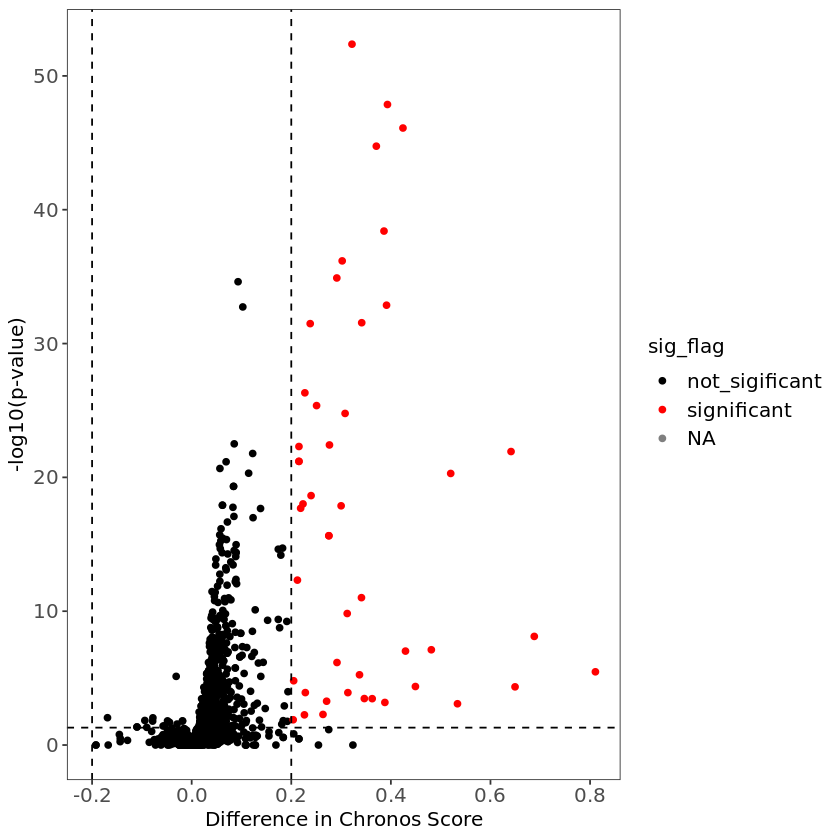

In [7]:
#Plot the plot
dataset.for.plotting %>%
ggplot(aes(x = differential, y = -log10(fdr), color = sig_flag)) +
geom_point() +
geom_hline(yintercept = -log10(0.05), linetype = 2) +
geom_vline(xintercept = 0.2, linetype = 2) +
geom_vline(xintercept = -0.2, linetype = 2) +
theme_bw() +

scale_color_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

scale_x_continuous(breaks = seq(-0.4, 0.8, by = 0.2)) +

ylab("-log10(p-value)") +
xlab("Difference in Chronos Score")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c2_volcano.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c2_volcano.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

The next analysis they wanted in commment #2 is they wanted to know how many genes have more than one guide affected.

To do this we can compute this for every cell line-gene pair, then plot it as a bar graph or something

In [159]:
#Create a guide-level snp matrix for downstream analysis
guide.level.snp.matrix = processed.genotype.matrix %>%
select(-snp) %>%
mutate(across(everything(), ~ gsub(2, 1, .))) %>%
mutate(across(where(is.character), as.numeric)) %>%
mutate("snp" = processed.genotype.matrix$snp, .before = 1)

#Now write the dataset
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
write.table(guide.level.snp.matrix, "guide.level.snp.matrix.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [27]:
#Create a dataset that has the true number of affected guides for each gene
true.number.of.affected.guides.df = processed.genotype.matrix %>%
select(-snp) %>%
mutate(across(everything(), ~ gsub(2, 1, .))) %>%
mutate(across(where(is.character), as.numeric)) %>%
mutate("snp" = processed.genotype.matrix$snp, .before = 1) %>%
mutate(snp = plyr::mapvalues(from = sgrna.mapping.file$sgrna, to = sgrna.mapping.file$gene, snp, warn_missing = FALSE)) %>%
aggregate(. ~ snp, FUN = sum) %>%
rename("gene" = snp) 

head(true.number.of.affected.guides.df)

,gene,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,ACH-000971,ACH-000178,ACH-000822,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A1BG,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
2,AADAC,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,AADACL2,1,1,1,0,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1
4,AADACL3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,AAMDC,1,1,1,1,1,0,0,1,0,⋯,1,1,0,1,0,1,0,1,0,1
6,AARSD1,1,1,1,1,1,1,1,1,1,⋯,1,1,1,1,1,1,1,1,1,1


In [46]:
#Across all samples, calculate the frequency of each event
frequency.of.gene.affected = true.number.of.affected.guides.df %>%
melt() %>%
group_by(value) %>%
summarise(n()) %>%
rename("num_guides_affected" = 1, "num_events" = 2) %>%
data.frame()

frequency.of.gene.affected

Using gene as id variables



num_guides_affected,num_events
<dbl>,<int>
0,2063102
1,874909
2,36702
3,3784
4,9971
5,1369
6,14
7,5
8,96


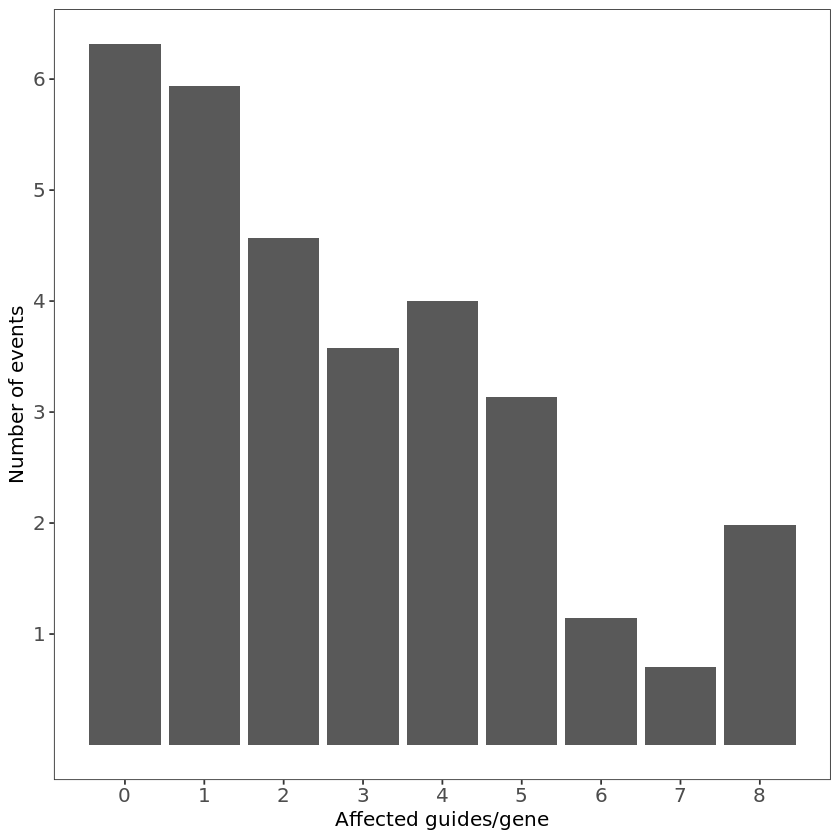

In [61]:
#Now make a plot of these data
frequency.of.gene.affected %>%
ggplot(aes(x = num_guides_affected, y = log10(num_events))) +
geom_bar(stat = "identity") +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

scale_x_continuous(breaks = seq(0, 8, by = 1)) +
scale_y_continuous(breaks = seq(1, 6, by = 1)) +

ylab("Number of events") +
xlab("Affected guides/gene")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c2_affected_guide_count.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c2_affected_guide_count.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

For each gene calculate the number of guides affected. This is different from the previous analysis because in this analysis if a single guide is affected in a single sample, then that's flagged as a 1. This analysis doesn't consider how many samples have that guide affected.

In [11]:
#Load in the guide matrix
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
guide.level.snp.matrix = read.table("guide.level.snp.matrix.txt", sep = "\t", header = TRUE)

head(guide.level.snp.matrix)

,snp,ACH.000657,ACH.000617,ACH.000685,ACH.000632,ACH.000171,ACH.000863,ACH.000971,ACH.000178,ACH.000822,⋯,ACH.000981,ACH.000217,ACH.000116,ACH.000930,ACH.000986,ACH.000342,ACH.001130,ACH.000287,ACH.000798,ACH.000645
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,AAAACTGTACGAGTGACGGA,0,0,0,1,1,1,1,0,0,⋯,1,0,1,1,0,0,1,1,1,1
2,AAAGCGGTCACCTTCCACAT,0,1,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,1,1,1,1
3,AAAGGAGTCGAAGAAGTCCG,0,1,1,1,1,1,0,1,1,⋯,1,1,1,1,1,1,1,0,1,1
4,AAAGGATGAAAGACTCCGAA,1,1,1,1,1,1,1,0,1,⋯,1,1,1,1,0,1,1,1,1,1
5,AAAGTGCAAGAGGATACCCA,1,1,1,1,1,1,1,0,1,⋯,1,0,1,1,1,1,0,1,1,1
6,AAAGTTTCTGTCTTACCTGG,1,1,1,0,0,1,1,1,1,⋯,0,1,0,1,1,1,1,1,1,1


In [4]:
#Load in ths sgrna mapping file
setwd("/home/jupyter/Ancestry/gwas")
sgrna.mapping.file = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",") %>%
select(sgrna, gene) %>%
mutate(gene = word(gene, 1))
head(sgrna.mapping.file)

,sgrna,gene
,<chr>,<chr>
1,AAAAAAATCCAGCAATGCAG,SHOC2
2,AAAAAACCCGTAGATAGCCT,NDUFA12
3,AAAAAAGAAGAAAAAACCAG,SDAD1
4,AAAAAAGCTCAAGAAGGAGG,FAM98A
5,AAAAAAGGCTGTAAAAGCGT,ZNF253
6,AAAAAAGGGCTCCAAAAAGG,H2BC7


In [12]:
affected.guides.per.gene %>% head()
unaffected.genes %>% head()

gene,count
<chr>,<int>
OR5H6,4
ADAM21,3
ATP5PO,3
C7orf31,3
CAPN14,3
ELOA2,3


,gene,count
,<chr>,<dbl>
1,OR5H6,0
2,ADAM21,0
3,ATP5PO,0
4,C7orf31,0
5,CAPN14,0
6,ELOA2,0


In [15]:
setdiff(sgrna.mapping.file$gene, affected.guides.per.gene$gene) %>% length()

[1] 15611

In [16]:
#Calculate the number of guides that are affected for each gene
affected.guides.per.gene = sgrna.mapping.file %>%
filter(sgrna %in% all_of(guide.level.snp.matrix$snp)) %>%
group_by(gene) %>%
summarise(n()) %>%
rename("count" = 2) %>%
arrange(desc(count))

#Figure out which genes are not affected
unaffected.genes = setdiff(sgrna.mapping.file$gene, affected.guides.per.gene$gene) %>%
data.frame() %>%
rename("gene" = 1) %>%
mutate("count" = 0)

#Cat them both together
final.affected.guides.per.gene = rbind(affected.guides.per.gene, unaffected.genes)

head(final.affected.guides.per.gene)


gene,count
<chr>,<dbl>
OR5H6,4
ADAM21,3
ATP5PO,3
C7orf31,3
CAPN14,3
ELOA2,3


In [17]:
#Get actual numbers so that we can report it in the response to reviewers
final.affected.guides.per.gene %>%
group_by(count) %>%
summarise(n())

count,n()
<dbl>,<int>
0,15611
1,2648
2,243
3,15
4,1


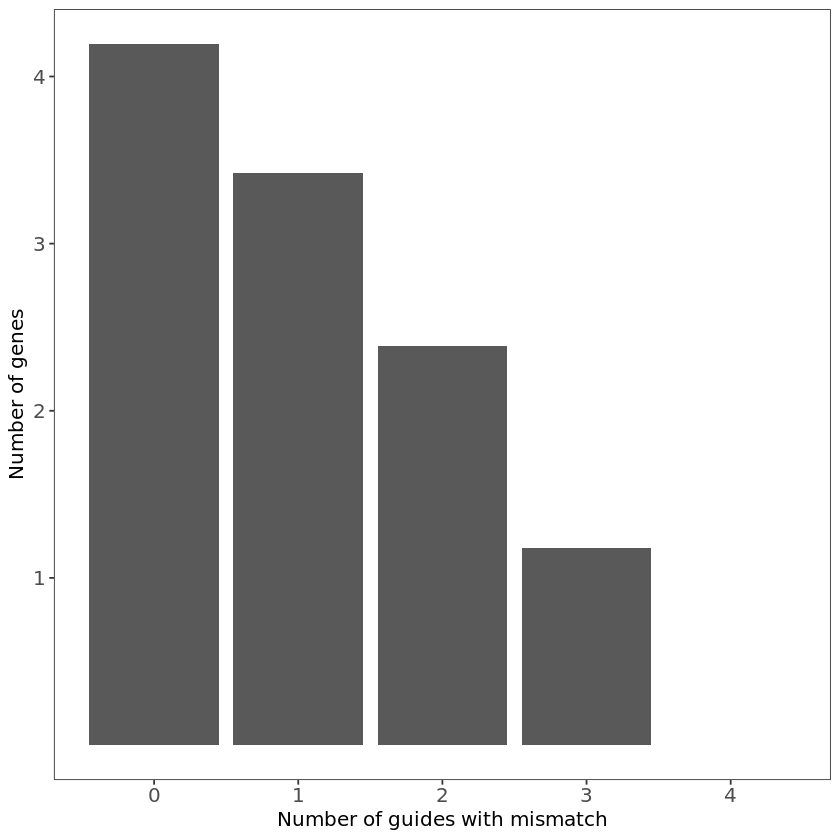

In [18]:
#Plot the plot
final.affected.guides.per.gene %>%
group_by(count) %>%
summarise(n()) %>%
rename("num" = 2) %>%

ggplot(aes(x = count, y = log10(num))) +
geom_bar(stat = "identity") +
theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

scale_x_continuous(breaks = seq(0, 8, by = 1)) +
scale_y_continuous(breaks = seq(1, 6, by = 1)) +

ylab("Number of genes") +
xlab("Number of guides with mismatch")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c2_affected_guide_count_simple.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c2_affected_guide_count_simple.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Perform an analysis of the DepMap guide blacklist data.

In [3]:
#Load in the DepMap guide blacklist data
avana.blacklist <- load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='OmicsGuideMutationsBinaryAvana')
humange.blacklist <- load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='OmicsGuideMutationsBinaryHumagne')
ky.blacklist <- load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='OmicsGuideMutationsBinaryKY')

#Load in the depmap guide maps
avana.guide.map = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='AvanaGuideMap') %>%
data.frame() %>%
mutate(Gene = word(Gene, 1))
humange.guide.map = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='HumagneGuideMap') %>%
data.frame() %>%
mutate(Gene = word(Gene, 1))
ky.guide.map = load.from.taiga(data.name='internal-23q2-1e49', data.version=97, data.file='KYGuideMap') %>%
data.frame() %>%
mutate(Gene = word(Gene, 1))

Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_omicsguidemutationsbinaryavana.rds



Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_omicsguidemutationsbinaryhumagne.rds



Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_omicsguidemutationsbinaryky.rds



Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_avanaguidemap.rds



Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_humagneguidemap.rds



Fetching https://cds.team/taiga/api/dataset/internal-23q2-1e49/97 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/internal-23q2-1e49_97.toc 


Loading from cached file /home/jupyter/.taiga/af6202f567224b5094aa0f9911f1d458_kyguidemap.rds



In [4]:
#Calculate the total number of lines a guide is blacklisted in 
avana.affected.rate = avana.blacklist %>%
select(-chrom, -start, -end, -sgRNA) %>%
apply(1, sum) %>%
cbind(avana.blacklist$sgRNA, .) %>%
data.frame() %>%
rename("sgrna" = 1, "num_affected" = 2) %>%
mutate("gene" = plyr::mapvalues(from = avana.guide.map$sgRNA, to = avana.guide.map$Gene, sgrna, warn_missing = FALSE)) %>%
mutate("dataset" = "avana")


humange.affected.rate = humange.blacklist %>%
select(-chrom, -start, -end, -sgRNA) %>%
apply(1, sum) %>%
cbind(humange.blacklist$sgRNA, .) %>%
data.frame() %>%
rename("sgrna" = 1, "num_affected" = 2) %>%
mutate("gene" = plyr::mapvalues(from = humange.guide.map$sgRNA, to = humange.guide.map$Gene, sgrna, warn_missing = FALSE)) %>%
mutate("dataset" = "humange")


ky.affected.rate = ky.blacklist %>%
select(-chrom, -start, -end, -sgRNA) %>%
apply(1, sum) %>%
cbind(ky.blacklist$sgRNA, .) %>%
data.frame() %>%
rename("sgrna" = 1, "num_affected" = 2) %>%
mutate("gene" = plyr::mapvalues(from = ky.guide.map$sgRNA, to = ky.guide.map$Gene, sgrna, warn_missing = FALSE)) %>%
mutate("dataset" = "ky")


In [5]:
#Load in the avana bed file
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) 
head(avana.bed)

,chr,start,end,sgrna
,<chr>,<int>,<dbl>,<chr>
1,chr1,69527,69550,TCTCCATTCGGTGAGCCAGT
2,chr1,168646,168669,TGTAGTCCCAGCTACTCAGG
3,chr1,383420,383443,GAGAATCTCTTGAACCCGGG
4,chr1,424270,424293,TGTAATCCCAGTACTTTGGG
5,chr1,451271,451294,ATAATGGTCAGATAGTGGAG
6,chr1,451344,451367,TCTCCACACCACCAACGACG


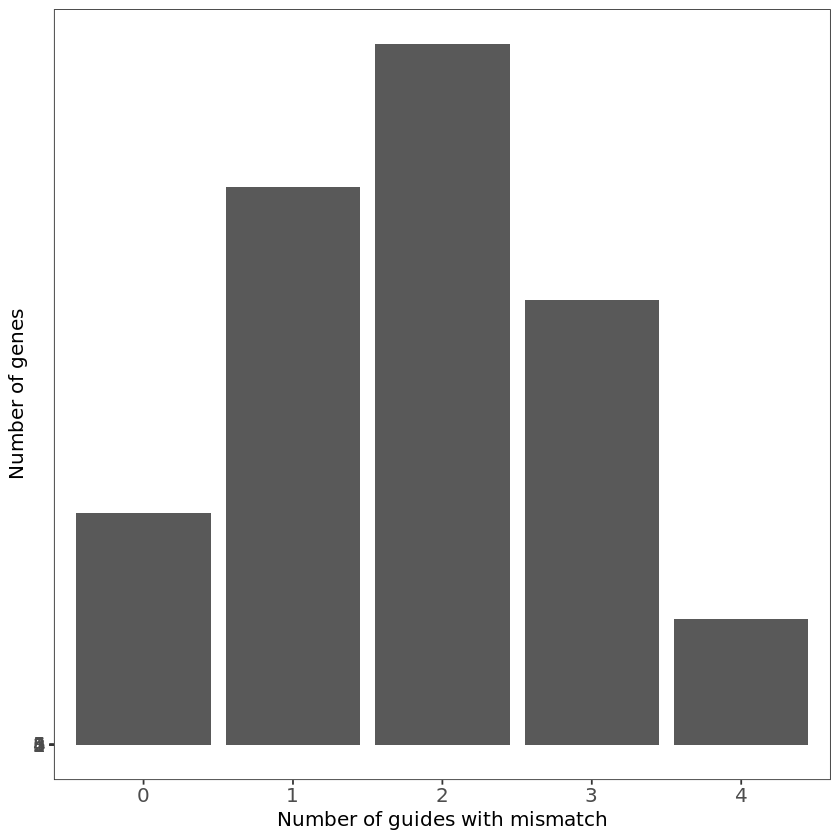

In [6]:
#Plot the plot
avana.affected.rate %>%
data.frame() %>%
filter(!str_detect(gene, 'INTERGENIC')) %>%
mutate(num_affected = as.numeric(num_affected)) %>%
filter(sgrna %in% all_of(avana.bed$sgrna)) %>%
mutate("is_affected" = ifelse(num_affected >= 1, 1, 0)) %>%
group_by(gene) %>%
summarise("num_guides_affected" = sum(is_affected)) %>%
group_by(num_guides_affected) %>%
summarise("num_genes_in_class" = n()) %>%
filter(num_guides_affected <= 4) %>%
ggplot(aes(x = as.character(num_guides_affected), y = num_genes_in_class)) +
geom_bar(stat = "identity") +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

scale_y_continuous(breaks = seq(1, 6, by = 1)) +

ylab("Number of genes") +
xlab("Number of guides with mismatch")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c2_affected_guide_count_blacklist.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c2_affected_guide_count_blacklist.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))


In [7]:
avana.affected.rate %>%
data.frame() %>%
filter(!str_detect(gene, 'INTERGENIC')) %>%
mutate(num_affected = as.numeric(num_affected)) %>%
filter(sgrna %in% all_of(avana.bed$sgrna)) %>%
mutate("is_affected" = ifelse(num_affected >= 1, 1, 0)) %>%
group_by(gene) %>%
summarise("num_guides_affected" = sum(is_affected)) %>%
group_by(num_guides_affected) %>%
summarise("num_genes_in_class" = n()) %>%
filter(num_guides_affected <= 4)

num_guides_affected,num_genes_in_class
<dbl>,<int>
0,2043
1,4918
2,6178
3,3923
4,1112


In [8]:
avana.affected.rate %>%
data.frame() %>%
filter(!str_detect(gene, 'INTERGENIC')) %>%
mutate(num_affected = as.numeric(num_affected))

sgrna,num_affected,gene,dataset
<chr>,<dbl>,<chr>,<chr>
GATCCTGGTAGTGAACGGCG,0,ESPN,avana
ACGCCAACTGGCTCACCGAA,0,OR4F5,avana
ATAATGGTCAGATAGTGGAG,0,OR4F21,avana
TCTCCACACCACCAACGACG,0,OR4F16,avana
GCTTGCCACATAGAGCACAG,0,OR4F3,avana
ATAATGGTCAGATAGTGGAG,0,OR4F21,avana
TCTCCACACCACCAACGACG,0,OR4F16,avana
GCTTGCCACATAGAGCACAG,0,OR4F3,avana
CTCCTTCTTCAGGTTCCGGG,2,SAMD11,avana


Make the rainbow plot, per Jesse's suggestions in one of our Friday meetings.

In [9]:
#Load in the most recent Chronos data from 23Q2
#We will use this data to subset the sequencing data so that it only includes lines with CRISPR screening data
chronos.lines = load.from.taiga(data.name='public-22q4-6837', data.version=78, data.file='CRISPRGeneEffect') %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
pull(sample) %>%
unique() 


#Calculate the intersecting lines between chronos and genotyping
samples.to.keep = intersect(chronos.lines, colnames(avana.blacklist))

Fetching https://cds.team/taiga/api/dataset/public-22q4-6837/78 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q4-6837_78.toc 


Loading from cached file /home/jupyter/.taiga/84642b75bf3b4f1e8b304c5014a57e65_crisprgeneeffect.rds



In [10]:
#Create a data frame with gene and number of cell lines affected
num.lines.affected = avana.blacklist %>%
select(-chrom, -start, -end, -sgRNA) %>%
select(all_of(samples.to.keep)) %>%
apply(1, sum) %>%
cbind(avana.blacklist$sgRNA, .) %>%
data.frame() %>%
rename("sgrna" = 1, "num_affected_lines" = 2) %>%
mutate(num_affected_lines = as.numeric(num_affected_lines)) %>%
arrange(desc(num_affected_lines)) %>%
mutate("gene" = plyr::mapvalues(from = avana.guide.map$sgRNA, to = avana.guide.map$Gene, sgrna, warn_missing = FALSE)) %>%
mutate("dataset" = "avana") %>%
filter(!str_detect(gene, 'INTERGENIC')) %>%
filter(sgrna %in% all_of(avana.bed$sgrna))

In [11]:
#Create a data frame that has the total number of guides affected (in at least one cell line)
num.guides.affected = avana.blacklist %>%
select(-chrom, -start, -end, -sgRNA) %>%
select(all_of(samples.to.keep)) %>%
apply(1, sum) %>%
cbind(avana.blacklist$sgRNA, .) %>%
data.frame() %>%
rename("sgrna" = 1, "num_affected_lines" = 2) %>%
mutate(num_affected_lines = as.numeric(num_affected_lines)) %>%
arrange(desc(num_affected_lines)) %>%
mutate("gene" = plyr::mapvalues(from = avana.guide.map$sgRNA, to = avana.guide.map$Gene, sgrna, warn_missing = FALSE)) %>% 
filter(sgrna %in% all_of(avana.bed$sgrna)) %>% 
mutate("is_affected" = ifelse(num_affected_lines >= 1, 1, 0)) %>%
group_by(gene) %>%
summarise("num_guides_affected" = sum(is_affected))

In [12]:
#Bind them both together 
combined.df.for.rainbow.plot = inner_join(num.lines.affected, num.guides.affected, by = "gene")

combined.df.for.rainbow.plot %>% head()

,sgrna,num_affected_lines,gene,dataset,num_guides_affected
,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,AGAAGAAATGGCAGTAAAGA,1031,FAM104B,avana,2
2,GAAATGCTAGAACATAAGTA,1019,IQSEC3,avana,3
3,TGGCGCGCAGGGCTATTGCG,1011,FAM110C,avana,2
4,TCTGCTCAGTAAGATCCGGG,946,TUBB8,avana,1
5,AGAGAAGCAGGATATGCGTT,525,GOLGA8R,avana,1
6,AATGCCTGGACACTGCACAG,230,ZNF85,avana,5


In [13]:
#Calculate the number of guide affected at each frequency
interval.frequency = combined.df.for.rainbow.plot %>% 
group_by(num_affected_lines) %>%
summarise("affected_interval" = n())

interval.frequency %>% head()

num_affected_lines,affected_interval
<dbl>,<int>
0,50490
1,16876
2,5126
3,1539
4,566
5,264


In [14]:
#Add the affected interval into combined.df.for.rainbow.plot
combined.df.for.rainbow.plot = combined.df.for.rainbow.plot %>%
mutate("affected_interval" = plyr::mapvalues(from = interval.frequency$num_affected_lines, to = interval.frequency$affected_interval, num_affected_lines, warn_missing = FALSE))


combined.df.for.rainbow.plot %>% head()

,sgrna,num_affected_lines,gene,dataset,num_guides_affected,affected_interval
,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,AGAAGAAATGGCAGTAAAGA,1031,FAM104B,avana,2,1
2,GAAATGCTAGAACATAAGTA,1019,IQSEC3,avana,3,1
3,TGGCGCGCAGGGCTATTGCG,1011,FAM110C,avana,2,1
4,TCTGCTCAGTAAGATCCGGG,946,TUBB8,avana,1,1
5,AGAGAAGCAGGATATGCGTT,525,GOLGA8R,avana,1,1
6,AATGCCTGGACACTGCACAG,230,ZNF85,avana,5,1


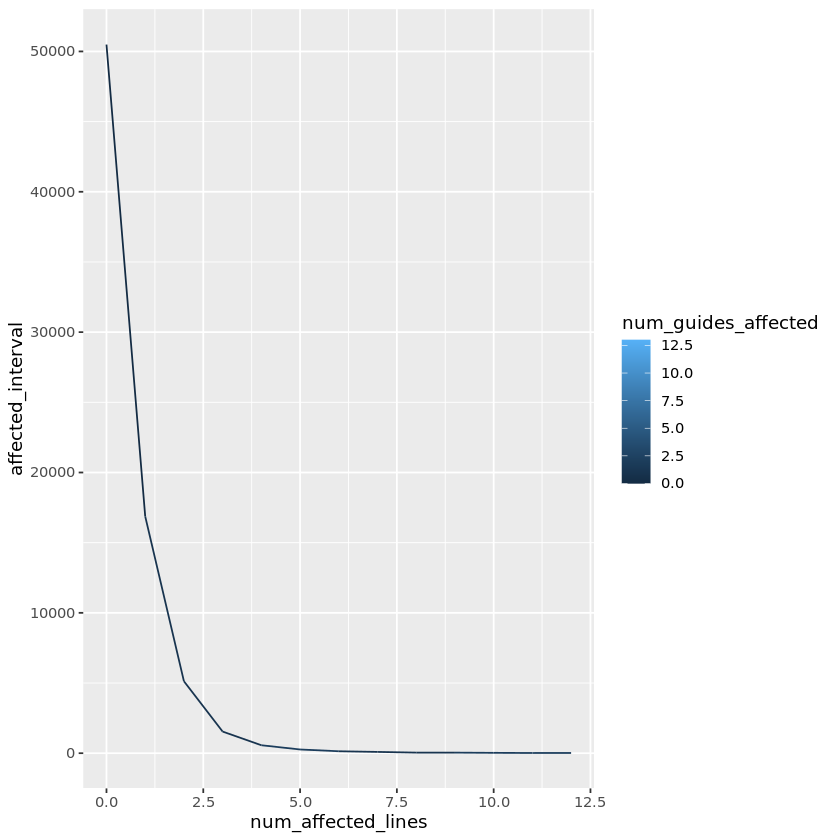

In [63]:
#Plot the plot
combined.df.for.rainbow.plot %>%
filter(affected_interval > 10) %>%
ggplot(aes(x =  num_affected_lines, y = affected_interval, color = num_guides_affected)) +
geom_line()

Remake figure 3B but with the WES/WGS data instead of the SNP6 data

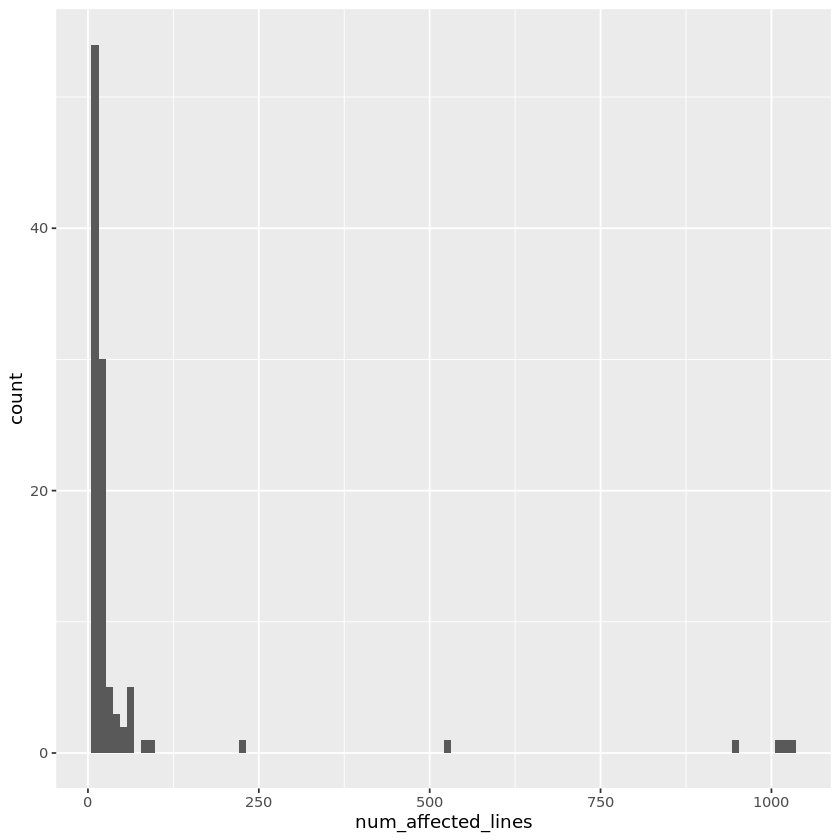

In [26]:
#Make figure 3B
combined.df.for.rainbow.plot %>%
mutate("fraction_guides_affected" = num_affected_lines/length(samples.to.keep)) %>%
filter(num_affected_lines > 10) %>%
ggplot(aes(x = num_affected_lines)) +
geom_histogram(bins = 100)

# Comment 3

In this comment we will re-do the PTPN11 GRB2 analysis so that we can add p-values. 

I will also look at guide-level differences for these two genes.

I will also do the same analysis in 22Q1 and 22Q2 depmap datasets.

In [11]:
#Load in the gene block matrix that lists the ancestry for all genes and for all cell lines
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

In [12]:
#Load in the chronos data and format it
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
ccle.chronos = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect', quiet = TRUE) %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
setNames(word(names(.), 1)) 
head(ccle.chronos)

#Load in the 22Q2 chronos scores
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
ccle.chronos.new = load.from.taiga(data.name = 'public-22q2-de04', data.version = 13, data.file = 'CRISPR_gene_effect', quiet = TRUE) %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
setNames(word(names(.), 1)) 
head(ccle.chronos.new)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.05643839,-0.1176586,-0.02720567,0.10508843,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.10724648,-0.2477974,0.16406170,0.05887251,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.05148461,-0.3344562,-0.11252650,-0.02517573,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.27257956,-0.4733824,0.06296188,0.18920560,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,-0.18239415,-0.3284529,0.01106695,0.18831931,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000011,0.08655529,-0.02187455,0.03975463,0.190257969,-0.08612250,-0.25863102,-0.05526859,-0.1497031,0.039875196,⋯,-0.64292819,-0.4389316,0.05385447,0.11210283,0.19190139,0.10649250,-0.10068460,-0.122768098,-0.12669751,-0.17658955


Fetching https://cds.team/taiga/api/dataset/public-22q2-de04/13 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q2-de04_13.toc 


Loading from cached file /home/jupyter/.taiga/1cafd2994fbd42bfa073735fd1df8fb1_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13480834,0.05976414,-0.008665348,-0.003572187,-0.10621134,-0.008256886,0.01871112,-0.2919850,0.010921115,⋯,-0.03761858,-0.1165238,-0.02933128,0.10593958,0.14760478,-0.11982188,0.06338746,0.160857427,0.05864839,-0.31679247
2,ACH-000004,0.08185267,-0.05640053,-0.106737674,-0.014498538,0.07820912,-0.137561629,0.16865681,-0.1985604,0.133372221,⋯,-0.03090052,-0.2622202,0.13640560,0.03132672,0.09376340,-0.07969233,-0.17370934,0.153631719,0.17562738,-0.04086936
3,ACH-000005,-0.09419603,-0.01459842,0.100426025,0.169102790,0.03236276,-0.148049517,0.16893121,-0.2447774,-0.086870802,⋯,0.03943419,-0.3369248,-0.09552776,-0.03554091,-0.03561198,-0.04018275,-0.16546361,0.077343176,0.01938719,-0.08568671
4,ACH-000007,-0.01154405,-0.12318890,0.080692206,0.061045542,-0.01345373,-0.016922117,-0.02947437,-0.2065158,-0.063998364,⋯,-0.22930329,-0.4631913,0.06164065,0.19030097,0.11938844,-0.03669501,-0.18244891,-0.146936282,-0.18945093,-0.28116666
5,ACH-000009,-0.05078233,-0.03746616,0.068885471,0.090375004,0.01263396,-0.079339046,-0.01780849,-0.1831923,0.006227123,⋯,-0.15721917,-0.3187652,0.01576143,0.19694914,-0.04587438,-0.18680541,-0.27562864,-0.001227225,-0.04913985,-0.24058191
6,ACH-000011,0.09176169,-0.02468473,0.038251266,0.202305191,-0.08956827,-0.238266134,-0.04224042,-0.1039025,0.048108927,⋯,-0.58992360,-0.4832944,0.06334174,0.11549458,0.20633287,0.09252132,-0.10991214,-0.121556159,-0.11373265,-0.20934415


In [13]:
#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))


head(formatted.gene.block.matrix)

,sample,TGIF1,PRDX6,CIC,PLEC,MPP2,CFTR,C1QB,ELN,SEPTIN12,⋯,GTF2H2C,TTC31,PDE8B,CHD1,PAK1,LOC284898,PRKD3,MLC1,ZBTB41,TMEM181
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000657,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000617,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,0,3
3,ACH-000685,0,0,3,0,0,0,0,0,3,⋯,0,0,0,0,0,0,0,3,0,2
4,ACH-000632,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000171,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000863,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


In [48]:
#Filter both datasets so that they share a common set of samples
intersecting.samples = intersect(ccle.chronos$sample, formatted.gene.block.matrix$sample)
intersecting.genes = intersect(colnames(ccle.chronos), colnames(formatted.gene.block.matrix))

final.ccle.chronos = ccle.chronos %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

final.ccle.chronos.new = ccle.chronos.new %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

final.gene.block = formatted.gene.block.matrix %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

dim(final.ccle.chronos)
dim(final.ccle.chronos.new)

[1]   611 16385

[1]   611 16385

In [17]:
#Grab PTPN11 and GRB2 from both data frames
chronos.shp2.ptpn11 = final.ccle.chronos %>% 
select(sample, PTPN11, GRB2) %>%
rename("chronos_ptpn11" = PTPN11, "chronos_grb2" = GRB2)

chronos.shp2.ptpn11.new = final.ccle.chronos.new %>% 
select(sample, PTPN11, GRB2) %>%
rename("chronos_ptpn11" = PTPN11, "chronos_grb2" = GRB2)

gene.block.shp2.ptpn11 = final.gene.block %>%
select(sample, PTPN11, GRB2) %>%
rename("block_ptpn11" = PTPN11, "block_grb2" = GRB2)

#merge the two datasets together
block.and.chronos = inner_join(chronos.shp2.ptpn11, gene.block.shp2.ptpn11, by = "sample") %>%
inner_join(., chronos.shp2.ptpn11.new, by = "sample") %>%
rename("ptpn11_chronos_old" = 2, "grb2_chronos_old" = 3, "ptpn11_chronos_new" = 6, "grb2_chronos_new" = 7)

head(block.and.chronos)

,sample,ptpn11_chronos_old,grb2_chronos_old,block_ptpn11,block_grb2,ptpn11_chronos_new,grb2_chronos_new
,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,ACH-000001,-0.5175887,-0.3501043,3,3,-0.5136898,-0.3711285
2,ACH-000004,-0.7212404,-0.6487567,3,3,-0.7355801,-0.6237439
3,ACH-000005,-1.0170940,-0.6915075,3,0,-0.9663754,-0.6502353
4,ACH-000007,-0.7956095,-0.8175380,3,3,-0.7580861,-0.8594133
5,ACH-000009,-0.8889995,-1.3572802,3,3,-0.8566251,-1.3764584
6,ACH-000012,-1.2340947,-1.2756595,3,3,-1.2721335,-1.3042782


In [20]:
#Calculate the p-values for grb2 and ptpn11
#a value of 2 in the block column means east asian and a value of 3 means european
ptpn11.eur.chronos = block.and.chronos %>% filter(block_ptpn11 %in% 3) %>% pull(ptpn11_chronos_old)
ptpn11.eas.chronos = block.and.chronos %>% filter(block_ptpn11 %in% 2) %>% pull(ptpn11_chronos_old)
grb2.eur.chronos = block.and.chronos %>% filter(block_ptpn11 %in% 3) %>% pull(grb2_chronos_old)
grb2.eas.chronos = block.and.chronos %>% filter(block_ptpn11 %in% 2) %>% pull(grb2_chronos_old)

ptpn11.pval = wilcox.test(ptpn11.eur.chronos, ptpn11.eas.chronos)$p.value
grb2.pval = wilcox.test(grb2.eur.chronos, grb2.eas.chronos)$p.value

ptpn11.pval
grb2.pval



ptpn11.eur.chronos.new = block.and.chronos %>% filter(block_ptpn11 %in% 3) %>% pull(ptpn11_chronos_new)
ptpn11.eas.chronos.new = block.and.chronos %>% filter(block_ptpn11 %in% 2) %>% pull(ptpn11_chronos_new)
grb2.eur.chronos.new = block.and.chronos %>% filter(block_ptpn11 %in% 3) %>% pull(grb2_chronos_new)
grb2.eas.chronos.new = block.and.chronos %>% filter(block_ptpn11 %in% 2) %>% pull(grb2_chronos_new)

ptpn11.pval.new = wilcox.test(ptpn11.eur.chronos.new, ptpn11.eas.chronos.new)$p.value
grb2.pval.new = wilcox.test(grb2.eur.chronos.new, grb2.eas.chronos.new)$p.value

ptpn11.pval.new
grb2.pval.new


[1] 5.410547e-06

[1] 1.110106e-07

[1] 3.579025e-06

[1] 1.775044e-07

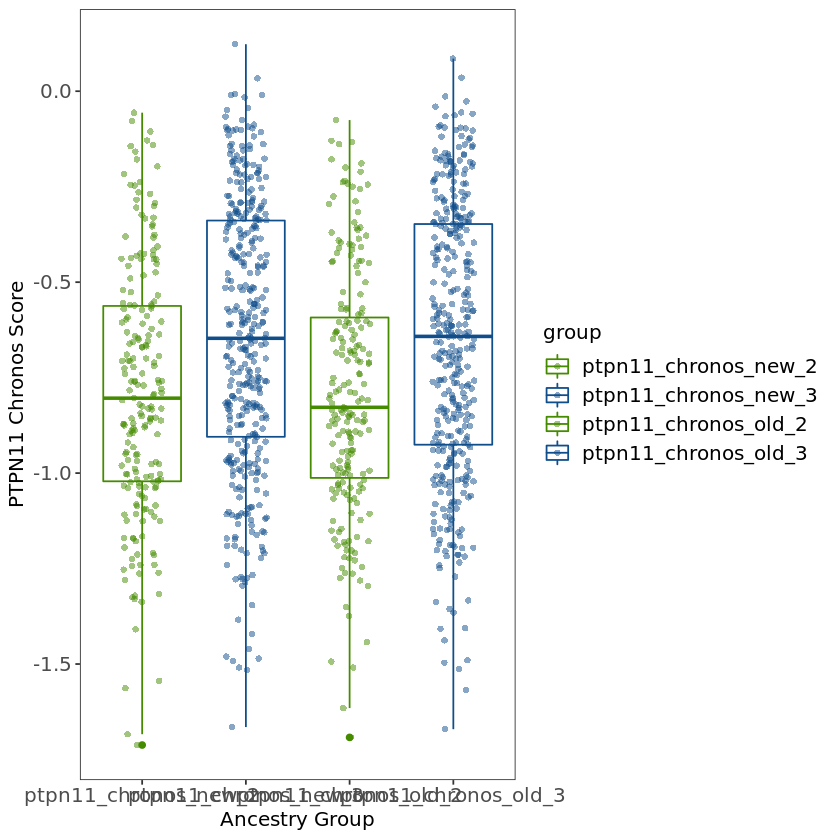

In [46]:
#Plot the data for ptpn11
block.and.chronos %>%
melt(id = c("block_ptpn11", "block_grb2", "sample")) %>%
filter(block_ptpn11 %in% c(2, 3)) %>%
filter(variable %in% c("ptpn11_chronos_old", "ptpn11_chronos_new")) %>%
mutate("group" = paste(variable, "_", block_ptpn11, sep = "")) %>%
ggplot(aes(x = group, y = value, color = group)) +
geom_boxplot() +
geom_jitter(shape=16, position = position_jitter(0.2), alpha = 0.5) +
scale_color_manual(values = c("chartreuse4", "dodgerblue4", "chartreuse4", "dodgerblue4")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("PTPN11 Chronos Score") +
xlab("Ancestry Group")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c3_ptpn11_violin.pdf", width = 6, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c3_ptpn11_violin.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

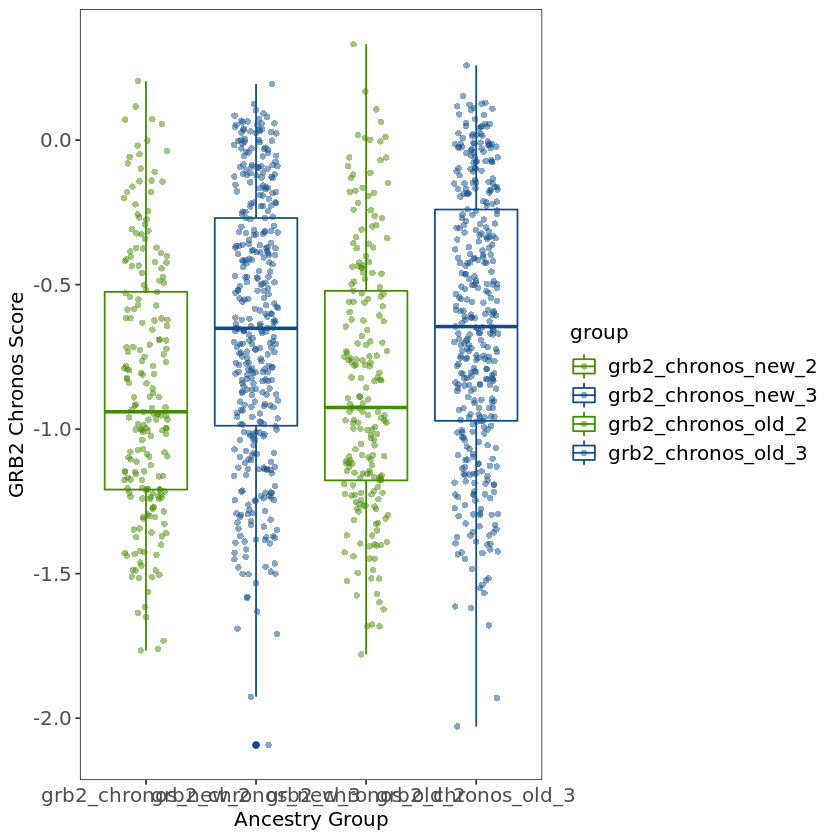

In [47]:
#Plot the data for grb2
block.and.chronos %>%
melt(id = c("block_ptpn11", "block_grb2", "sample")) %>%
filter(block_grb2 %in% c(2, 3)) %>%
filter(variable %in% c("grb2_chronos_old", "grb2_chronos_new")) %>%
mutate("group" = paste(variable, "_", block_grb2, sep = "")) %>%
ggplot(aes(x = group, y = value, color = group)) +
geom_boxplot() +
geom_jitter(shape=16, position = position_jitter(0.2), alpha = 0.5) +
scale_color_manual(values = c("chartreuse4", "dodgerblue4", "chartreuse4", "dodgerblue4")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("GRB2 Chronos Score") +
xlab("Ancestry Group")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c3_grb2_violin.pdf", width = 6, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c3_grb2_violin.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Now generate the guide-level plots using both the 22Q1 and 22Q2 datasets

In [60]:
#First, load in the guide-level data

#Data for 22Q1
replicate.map.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_replicate_map', quiet = TRUE) %>% data.frame(check.names = FALSE)
guide.map.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_guide_map', quiet = TRUE) %>% data.frame(check.names = FALSE)
logfc.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_logfold_change', quiet = TRUE) %>% data.frame(check.names = FALSE) %>% rownames_to_column("sgrna")

#Data for 22Q2
replicate.map.22q2 = load.from.taiga(data.name='public-22q2-de04', data.version=14, data.file='Achilles_replicate_map') %>% data.frame(check.names = FALSE)
guide.map.22q2 = load.from.taiga(data.name='public-22q2-de04', data.version=14, data.file='Achilles_guide_map') %>% data.frame(check.names = FALSE)
logfc.22q2 = load.from.taiga(data.name='public-22q2-de04', data.version=14, data.file='Achilles_logfold_change') %>% data.frame(check.names = FALSE) %>% rownames_to_column("sgrna")

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-replicate-map.rds



Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-guide-map.rds



Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-logfold-change.rds



Fetching https://cds.team/taiga/api/dataset/public-22q2-de04/14 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q2-de04_14.toc 


Loading from cached file /home/jupyter/.taiga/72c31542d4034fd8aa4f0b25e91e8ce6_achilles-replicate-map.rds



Fetching https://cds.team/taiga/api/dataset/public-22q2-de04/14 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q2-de04_14.toc 


Loading from cached file /home/jupyter/.taiga/72c31542d4034fd8aa4f0b25e91e8ce6_achilles-guide-map.rds



Fetching https://cds.team/taiga/api/dataset/public-22q2-de04/14 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q2-de04_14.toc 


Loading from cached file /home/jupyter/.taiga/72c31542d4034fd8aa4f0b25e91e8ce6_achilles-logfold-change.rds



In [138]:
#Load in the ancestry information and create two vectors with the EAS and EUR lines
#Load in the ancestry data
setwd("/home/jupyter/Ancestry/rfmix")
ancestry.information = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T)

#Get a vector of the EAS and EUR cell lines
eas.lines = ancestry.information %>% filter(EAS >= 0.8) %>% pull(sample)
eur.lines = ancestry.information %>% filter(EUR >= 0.8) %>% pull(sample)

In [139]:
#Get to vectors that contain all of the guides that we want to keep
#As it turns out, they're both the same, so we can just create one variable for both datasets
guides.to.keep = guide.map.22q1 %>% 
mutate(gene = word(gene, 1)) %>%
filter(gene %in% c("PTPN11", "GRB2")) 

head(guides.to.keep)

,sgrna,genome_alignment,gene,n_alignments
,<chr>,<chr>,<chr>,<int>
1,AATTGAACTTCACCACCCAG,chr17_75321764_+,GRB2,1
2,CGACGAGCTGAGCTTCAAAA,chr17_75393570_-,GRB2,1
3,CGAGCTGAGCTTCAAAAGGG,chr17_75393567_-,GRB2,1
4,GGAGGAACATGACATCGCGG,chr12_112419120_+,PTPN11,1
5,GTAGGATCTGCACAGTTCAG,chr12_112450486_-,PTPN11,2
6,GTGCAGATCCTACCTCTGAA,chr12_112450507_+,PTPN11,1


In [140]:
#First, subset the logfc data so that it only includes the guides we are interested in.
#Then collapse and average by sample
#Do it for 22q1
guide.level.data.22q1 = logfc.22q1 %>%
rename("sgrna" = 1) %>%
filter(sgrna %in% all_of(guides.to.keep$sgrna)) %>%
t() %>%
row_to_names(1, remove_rows_above = FALSE) %>%
data.frame() %>%
rownames_to_column("sample") %>%
mutate(sample = plyr::mapvalues(sample, from = replicate.map.22q1$replicate_ID, to = replicate.map.22q1$DepMap_ID, warn_missing = FALSE)) %>%
melt(id = "sample") %>%
mutate(value = as.numeric(value))%>%
group_by(sample, variable) %>%
summarise(mean(value)) %>%
dcast(sample ~ variable)

#Now do it for 22q2
guide.level.data.22q2 = logfc.22q2 %>%
rename("sgrna" = 1) %>%
filter(sgrna %in% all_of(guides.to.keep$sgrna)) %>%
t() %>%
row_to_names(1, remove_rows_above = FALSE) %>%
data.frame() %>%
rownames_to_column("sample") %>%
mutate(sample = plyr::mapvalues(sample, from = replicate.map.22q2$replicate_ID, to = replicate.map.22q2$DepMap_ID, warn_missing = FALSE)) %>%
melt(id = "sample") %>%
mutate(value = as.numeric(value))%>%
group_by(sample, variable) %>%
summarise(mean(value)) %>%
dcast(sample ~ variable)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
Using mean(value) as value column: use value.var to override.

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
Using mean(value) as value column: use value.var to override.



In [141]:
#Create a unified dataset with all of these guides
colnames(guide.level.data.22q1) = paste("22q1_", colnames(guide.level.data.22q1))
colnames(guide.level.data.22q2) = paste("22q2_", colnames(guide.level.data.22q2))

#Fix the column names
guide.level.data.22q1 = guide.level.data.22q1 %>% rename("sample" = 1) 
guide.level.data.22q2 = guide.level.data.22q2 %>% rename("sample" = 1) 

merged.guide.level.data.ptpn11.grb2 = inner_join(guide.level.data.22q1, guide.level.data.22q2, by = "sample")
colnames(merged.guide.level.data.ptpn11.grb2) = gsub("\\..*", "", colnames(merged.guide.level.data.ptpn11.grb2))

In [142]:
#Melt the dataset and make it look nice
final.dataset.for.plotting = merged.guide.level.data.ptpn11.grb2 %>%
melt() %>%
mutate("ancestry" = sample) %>%
filter(sample %in% eas.lines | sample %in% eur.lines) %>%
mutate(ancestry = ifelse(ancestry %in% all_of(eas.lines), "eas", 
                        ifelse(ancestry %in% all_of(eur.lines), "eur", "NA"))) %>%
mutate("dataset" = gsub("_..*", "", variable)) %>%
mutate("guide" = gsub("..*_", "", variable)) %>%
mutate(guide = gsub(" ", "", guide)) %>% #Fix the white space issue in the "guide" column
mutate("gene" = plyr::mapvalues(from = guides.to.keep$sgrna, to = guides.to.keep$gene, guide)) %>%
mutate(variable = paste(variable, "_", ancestry, sep = ""))


head(final.dataset.for.plotting)

Using sample as id variables



,sample,variable,value,ancestry,dataset,guide,gene
,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,ACH-000004,22q1_ AATTGAACTTCACCACCCAG_eur,-0.4701752,eur,22q1,AATTGAACTTCACCACCCAG,GRB2
2,ACH-000005,22q1_ AATTGAACTTCACCACCCAG_eur,-0.1473501,eur,22q1,AATTGAACTTCACCACCCAG,GRB2
3,ACH-000007,22q1_ AATTGAACTTCACCACCCAG_eur,-0.7147319,eur,22q1,AATTGAACTTCACCACCCAG,GRB2
4,ACH-000009,22q1_ AATTGAACTTCACCACCCAG_eur,-1.6520480,eur,22q1,AATTGAACTTCACCACCCAG,GRB2
5,ACH-000012,22q1_ AATTGAACTTCACCACCCAG_eur,-2.1031096,eur,22q1,AATTGAACTTCACCACCCAG,GRB2
6,ACH-000013,22q1_ AATTGAACTTCACCACCCAG_eur,0.1107878,eur,22q1,AATTGAACTTCACCACCCAG,GRB2


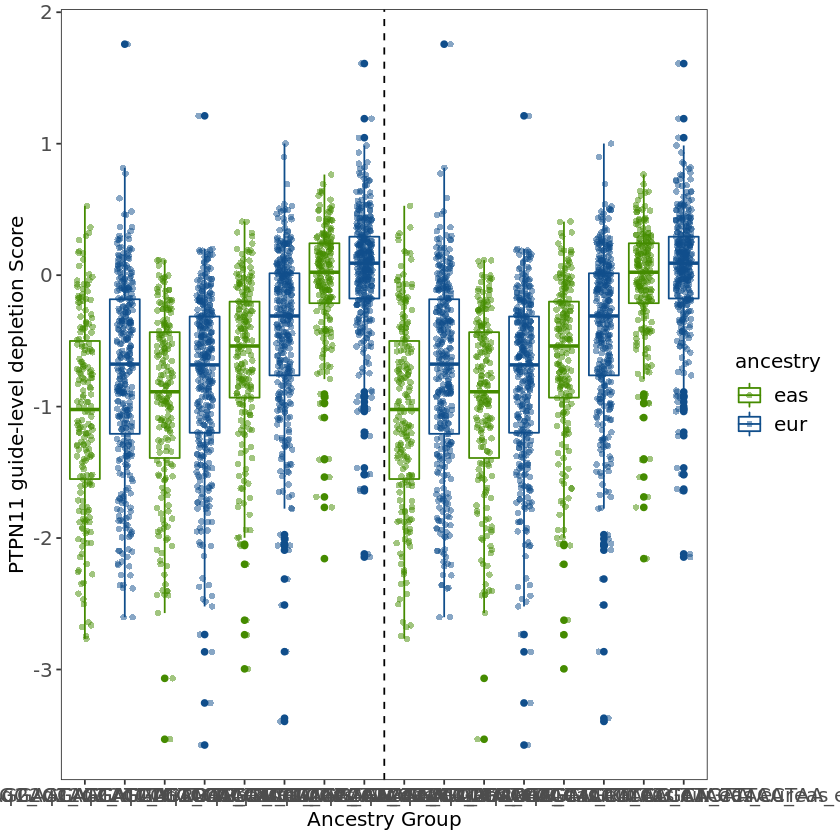

In [146]:
#Now plot the plot for ptpn11
final.dataset.for.plotting %>%
filter(gene %in% "PTPN11") %>%
ggplot(aes(x = variable, y = value, color = ancestry)) +
geom_boxplot() +
geom_jitter(shape=16, position = position_jitter(0.2), alpha = 0.5) +
geom_vline(xintercept = 8.5, linetype = 2) +
scale_color_manual(values = c("chartreuse4", "dodgerblue4")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("PTPN11 guide-level depletion Score") +
xlab("Ancestry Group")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c3_ptpn11_guide_level.pdf", width = 6, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c3_ptpn11_guide_level.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


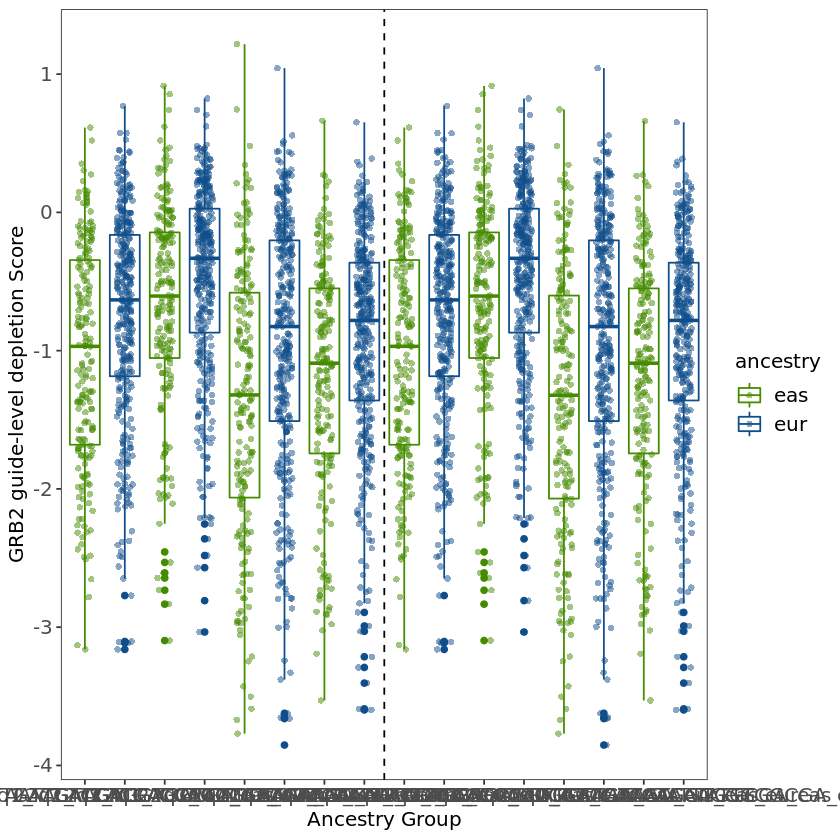

In [147]:
#Now plot the plot for grb2
final.dataset.for.plotting %>%
filter(gene %in% "GRB2") %>%
ggplot(aes(x = variable, y = value, color = ancestry)) +
geom_boxplot() +
geom_jitter(shape=16, position = position_jitter(0.2), alpha = 0.5) +
geom_vline(xintercept = 8.5, linetype = 2) +
scale_color_manual(values = c("chartreuse4", "dodgerblue4")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text=element_text(size = 12),
axis.title=element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("GRB2 guide-level depletion Score") +
xlab("Ancestry Group")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c3_grb2_guide_level.pdf", width = 6, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c3_grb2_guide_level.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Now, for the final point in this question, calculate the frequency at which the GRB2 and PTPN11 guides are mutated in the dataset.

After some analysis, there are zero SNPs in any of the GRB2 or PTPN11 guides across all samples in the dataset.

# Comment 4

The goal of the analysis in this comment is to calculate if there are differences in the random forest prediction models.

I can't find the predictive models for the older versions of the dataset

As a secondary approach to addressing this comment, we will search for instances in which a cell line has a classical marker for gene X sensitivity (e.g. BRAF mutation -> BRAF sensitivity), then find instances in which guides targeting that gene do not impact cell viability.

In [5]:
#Load in the guide-level data for 22q1
replicate.map.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_replicate_map', quiet = TRUE) %>% data.frame(check.names = FALSE)
guide.map.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_guide_map', quiet = TRUE) %>% data.frame(check.names = FALSE)
logfc.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='Achilles_logfold_change', quiet = TRUE) %>% data.frame(check.names = FALSE) %>% rownames_to_column("sgrna")

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-replicate-map.rds



Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-guide-map.rds



Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_achilles-logfold-change.rds



In [38]:
#Create a guide to gene bridging file
guide.to.gene.bridge = guide.map.22q1 %>%
mutate(gene = word(gene, 1))

guide.to.gene.bridge %>% head()

,sgrna,genome_alignment,gene,n_alignments
,<chr>,<chr>,<chr>,<int>
1,AAAAAAATCCAGCAATGCAG,chr10_110964620_+,SHOC2,1
2,AAAAAACCCGTAGATAGCCT,chr12_95003615_+,NDUFA12,1
3,AAAAAAGAAGAAAAAACCAG,chr4_75970356_-,SDAD1,1
4,AAAAAAGCTCAAGAAGGAGG,chr2_33588446_-,FAM98A,1
5,AAAAAAGGCTGTAAAAGCGT,chr19_19891600_+,ZNF253,1
6,AAAAAAGGGCTCCAAAAAGG,chr6_26199607_+,H2BC7,1


In [91]:
#Get a vector of guides that we want to keep
guides.to.keep = guide.map.22q1 %>%
mutate(gene = word(gene, 1)) %>%
filter(gene %in% c("BRAF", "KRAS", "TP53")) %>%
pull(sgrna) %>%
unique()

In [92]:
#Properly format the 22q1 guide-level data
guide.level.data.22q1 = logfc.22q1 %>%
rename("sgrna" = 1) %>%
filter(sgrna %in% all_of(guides.to.keep)) %>%
t() %>%
row_to_names(1, remove_rows_above = FALSE) %>%
data.frame() %>%
rownames_to_column("sample") %>%
mutate(sample = plyr::mapvalues(sample, from = replicate.map.22q1$replicate_ID, to = replicate.map.22q1$DepMap_ID, warn_missing = FALSE)) %>%
melt(id = "sample") %>%
mutate(value = as.numeric(value))%>%
group_by(sample, variable) %>%
summarise(mean(value)) %>%
dcast(sample ~ variable)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
Using mean(value) as value column: use value.var to override.



In [93]:
#Load in other useful datasets

#Load in the ccle hotspot mutation matrix
hotspot.mutations.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CCLE_mutations_bool_hotspot')

#Load in the guide blacklist matrix (from 22q4)
guide.blacklist.matrix.22q4 = load.from.taiga(data.name='public-22q4-6837', data.version=78, data.file='OmicsGuideMutationsBinaryAvana') 

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_ccle-mutations-bool-hotspot.rds



Fetching https://cds.team/taiga/api/dataset/public-22q4-6837/78 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q4-6837_78.toc 


Loading from cached file /home/jupyter/.taiga/84642b75bf3b4f1e8b304c5014a57e65_omicsguidemutationsbinaryavana.rds



In [94]:
#Create two vectors of cell lines with BRAF and KRAS hotspot mutations

#Do it for braf
lines.with.braf.hotspot = hotspot.mutations.22q1 %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
rename_all(~str_remove_all(., "\\s.*")) %>%
filter(BRAF %in% 1) %>%
pull(sample)

#Do it for kras
lines.with.kras.hotspot = hotspot.mutations.22q1 %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
rename_all(~str_remove_all(., "\\s.*")) %>%
filter(KRAS %in% 1) %>%
pull(sample)

#Do it for tp53
lines.with.tp53.hotspot = hotspot.mutations.22q1 %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
rename_all(~str_remove_all(., "\\s.*")) %>%
filter(TP53 %in% 1) %>%
pull(sample)

In [95]:
#Create an annotation matrix that has the affected guides for the genes of interest
affected.guide.annotation.df = guide.blacklist.matrix.22q4 %>%
select(-chrom, -start, -end) %>%
rename("sgrna" = sgRNA) %>%
filter(sgrna %in% all_of(guides.to.keep)) %>%
melt(id = "sgrna") %>%
mutate("flag" = paste(sgrna, "_", variable, sep = ""))

affected.guide.annotation.df %>% head()

,sgrna,variable,value,flag
,<chr>,<fct>,<int>,<chr>
1,AGAGGAGTACAGTGCAATGA,ACH-000440,0,AGAGGAGTACAGTGCAATGA_ACH-000440
2,AATTACTACTTGCTTCCTGT,ACH-000440,0,AATTACTACTTGCTTCCTGT_ACH-000440
3,TCCCTTCTCAGGATTCCTAC,ACH-000440,0,TCCCTTCTCAGGATTCCTAC_ACH-000440
4,CGAATATGATCCAACAATAG,ACH-000440,0,CGAATATGATCCAACAATAG_ACH-000440
5,GCAGTCACAGCACATGACGG,ACH-000440,0,GCAGTCACAGCACATGACGG_ACH-000440
6,GCTTGTAGATGGCCATGGCG,ACH-000440,0,GCTTGTAGATGGCCATGGCG_ACH-000440


In [96]:
#Construct a dataset that has all of the guide-level data for BRAF and KRAS
dataset.for.plotting = logfc.22q1 %>% 
filter(sgrna %in% all_of(guides.to.keep)) %>%
melt(id = "sgrna") %>%
mutate("cell_line" = plyr::mapvalues(from = replicate.map.22q1$replicate_ID, to = replicate.map.22q1$DepMap_ID, variable, warn_missing = FALSE)) %>%
select(-variable) %>%
group_by(sgrna, cell_line) %>%
summarise("logfc" = mean(value)) %>%
mutate("gene" = plyr::mapvalues(from = guide.to.gene.bridge$sgrna, to = guide.to.gene.bridge$gene, sgrna, warn_missing = FALSE)) %>%
mutate("flag" = paste(sgrna, "_", cell_line, sep = "")) %>%
mutate("snp_in_guide_status" = plyr::mapvalues(from = affected.guide.annotation.df$flag, to = affected.guide.annotation.df$value, flag, warn_missing = FALSE)) %>%
select(-flag) %>%
mutate("kras_hotspot_status" = ifelse(cell_line %in% all_of(lines.with.kras.hotspot), TRUE, FALSE)) %>%
mutate("braf_hotspot_status" = ifelse(cell_line %in% all_of(lines.with.braf.hotspot), TRUE, FALSE)) %>%
mutate("tp53_hotspot_status" = ifelse(cell_line %in% all_of(lines.with.tp53.hotspot), TRUE, FALSE))

dataset.for.plotting %>% head()

`summarise()` has grouped output by 'sgrna'. You can override using the
`.groups` argument.


sgrna,cell_line,logfc,gene,snp_in_guide_status,kras_hotspot_status,braf_hotspot_status,tp53_hotspot_status
<chr>,<fct>,<dbl>,<chr>,<chr>,<lgl>,<lgl>,<lgl>
AATCAACCCACAGCTGCACA,ACH-001001,0.387921310,TP53,0,TRUE,FALSE,TRUE
AATCAACCCACAGCTGCACA,ACH-002399,0.479605176,TP53,0,FALSE,FALSE,TRUE
AATCAACCCACAGCTGCACA,ACH-000948,1.185105676,TP53,0,FALSE,FALSE,FALSE
AATCAACCCACAGCTGCACA,ACH-000011,3.432822842,TP53,0,FALSE,FALSE,FALSE
AATCAACCCACAGCTGCACA,ACH-000323,-0.124025705,TP53,0,FALSE,FALSE,TRUE
AATCAACCCACAGCTGCACA,ACH-000905,-0.005495178,TP53,0,FALSE,FALSE,TRUE


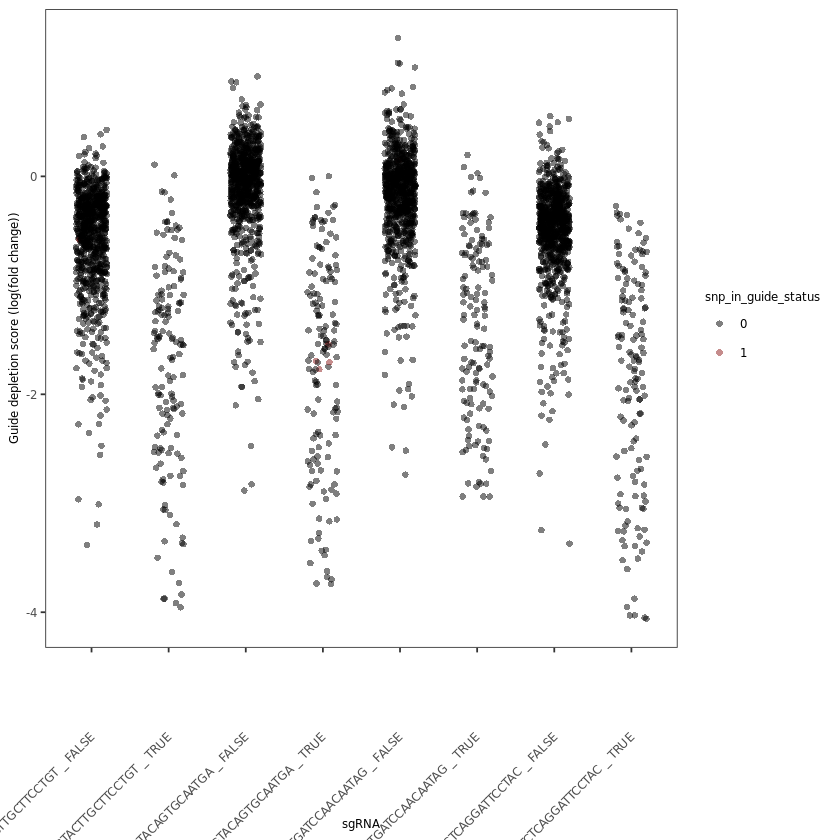

In [97]:
#Plot the plot (for kras)!
dataset.for.plotting %>%
mutate("tmp_axis" = paste(sgrna, "_", kras_hotspot_status)) %>%
filter(snp_in_guide_status %in% c(0, 1)) %>%
filter(gene %in% "KRAS") %>%
ggplot(aes(x = tmp_axis, y = logfc, color = snp_in_guide_status)) +
geom_jitter(shape=16, position = position_jitter(0.2), alpha = 0.5) +

theme(
legend.position="none"
) +

scale_color_manual(values = c("black", "firebrick4")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1)
) +

ylab("Guide depletion score (log(fold change))") +
xlab("sgRNA")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c4_kras_jitter.pdf", width = 6, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c4_kras_jitter.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

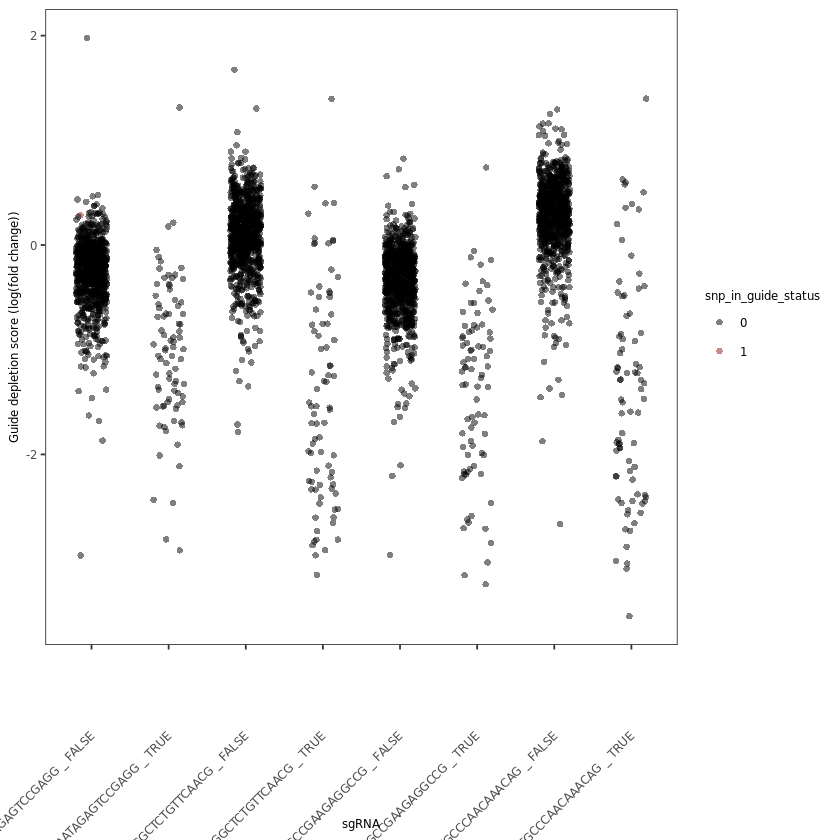

In [98]:
#Plot the plot (for braf)!
dataset.for.plotting %>%
mutate("tmp_axis" = paste(sgrna, "_", braf_hotspot_status)) %>%
filter(snp_in_guide_status %in% c(0, 1)) %>%
filter(gene %in% "BRAF") %>%
ggplot(aes(x = tmp_axis, y = logfc, color = snp_in_guide_status)) +
geom_jitter(shape=16, position = position_jitter(0.2), alpha = 0.5) +

theme(
legend.position="none"
) +

scale_color_manual(values = c("black", "firebrick4")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1)
) +

ylab("Guide depletion score (log(fold change))") +
xlab("sgRNA")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c4_braf_jitter.pdf", width = 6, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c4_braf_jitter.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

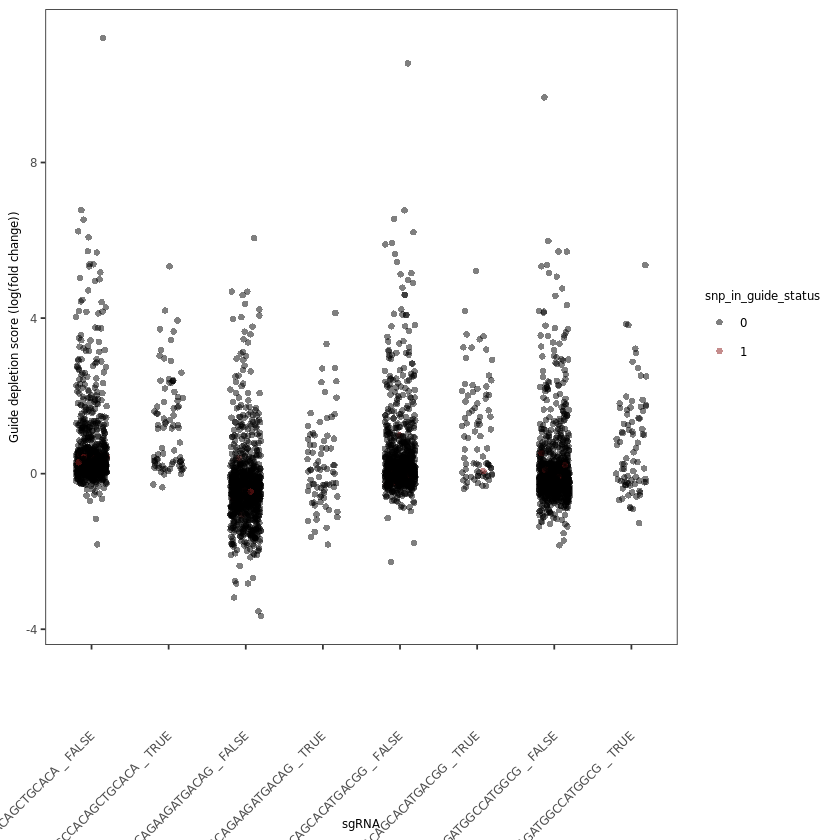

In [99]:
#Plot the plot (for tp53)!
dataset.for.plotting %>%
mutate("tmp_axis" = paste(sgrna, "_", braf_hotspot_status)) %>%
filter(snp_in_guide_status %in% c(0, 1)) %>%
filter(gene %in% "TP53") %>%
ggplot(aes(x = tmp_axis, y = logfc, color = snp_in_guide_status)) +
geom_jitter(shape=16, position = position_jitter(0.2), alpha = 0.5) +

theme(
legend.position="none"
) +

scale_color_manual(values = c("black", "firebrick4")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 7),
axis.title.y = element_text(size = 7)
) +

theme(
axis.text=element_text(size = 7),
axis.title=element_text(size = 7)
) +

theme(
legend.title = element_text(size = 7),
legend.text = element_text(size = 7)
) +

theme(
axis.text.x = element_text(angle = 45, vjust = 0.5, hjust=1)
) +

ylab("Guide depletion score (log(fold change))") +
xlab("sgRNA")


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c4_tp53_jitter.pdf", width = 6, height = 4)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c4_tp53_jitter.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Both BRAF and KRAS don't have very many germline mutations in guides. As a final attempt, let's compute which genes with "hotspot mutations" (according to depmap) are most affected by SNVs in guides.

In [69]:
#Get a vector of all genes with hotspot mutations
all.genes.with.hotspot.mutations = colnames(hotspot.mutations.22q1) %>%
word(., 1)

In [83]:
###Compute the guide affected rate for all hotspot genes

#First get a vector of all guides that target hotspot genes
hotspot.guides.to.keep = guide.map.22q1 %>%
mutate(gene = word(gene, 1)) %>%
filter(gene %in% all_of(all.genes.with.hotspot.mutations)) %>%
pull(sgrna)

#Figure out which hotspot guides are most affected
hotspot.guides.most.affected.df = guide.blacklist.matrix.22q4 %>%
select(-chrom, -start, -end) %>%
rename("sgrna" = sgRNA) %>%
filter(sgrna %in% all_of(hotspot.guides.to.keep)) %>%
melt() %>%
group_by(sgrna) %>%
summarise("num_affected_lines" = sum(value)) %>%
mutate(gene = plyr::mapvalues(from = guide.to.gene.bridge$sgrna, to = guide.to.gene.bridge$gene, sgrna, warn_missing = FALSE)) %>%
arrange(desc(num_affected_lines))


#Look at the data
hotspot.guides.most.affected.df %>%
head(n = 25)

Using sgrna as id variables



sgrna,num_affected_lines,gene
<chr>,<int>,<chr>
GAAATGCTAGAACATAAGTA,1567,IQSEC3
CCTACCTTGAAGGTGAACAG,80,TYRO3
TATTGGATACAAAGCAAAAG,45,VN1R2
TTCATGGGTGAACTGGCCCG,41,HLA-DOA
GGCCATAGAATTCTCTCTGG,33,ZNF730
TCAGGATTGTAAGCACCCCC,32,CYP2C19
TCTGCCCCTCCGAATCAAAG,31,HYDIN
ACTGGAGCTGCAGGTCCCAC,30,KRTAP1-5
CTATCGCGCAGGGGACCCCG,28,CLIP3


# Comment 6

The goal of this analysis is to calculate if Chronos score differ between 22Q1 and 22Q2.

Also, need to compute ancestry-assocated gene dependencies between 22Q1 and 22Q2, then compare the p-values (make scatter plot)

Also should probably just do the same thing for the snp-gene associations that I did in one of the previous comments

In [3]:
#Load in the chronos data and format it
ccle.chronos = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_gene_effect', quiet = TRUE) %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
setNames(word(names(.), 1)) 
head(ccle.chronos)

#Load in the 22Q2 chronos scores
ccle.chronos.new = load.from.taiga(data.name = 'public-22q2-de04', data.version = 13, data.file = 'CRISPR_gene_effect', quiet = TRUE) %>%
data.frame(check.names = FALSE) %>%
rownames_to_column("sample") %>%
setNames(word(names(.), 1)) 
head(ccle.chronos.new)

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13022665,0.04367100,-0.01067785,-0.003038938,-0.10651800,-0.01895532,0.01761511,-0.2805246,0.011350472,⋯,-0.05643839,-0.1176586,-0.02720567,0.10508843,0.14350973,-0.10492678,0.06582083,0.161843495,0.05662022,-0.31553541
2,ACH-000004,0.08567935,-0.06229549,-0.11627584,-0.049394700,0.06851031,-0.13422925,0.15372455,-0.2020006,0.132896655,⋯,-0.10724648,-0.2477974,0.16406170,0.05887251,0.07353784,0.08136490,-0.17123188,0.150911988,0.15923277,-0.04082740
3,ACH-000005,-0.09358537,0.04150119,0.07531566,0.149414781,0.03169255,-0.23687679,0.15381363,-0.2454794,-0.115307222,⋯,-0.05148461,-0.3344562,-0.11252650,-0.02517573,-0.04089682,-0.17509416,-0.13905023,0.090325195,0.02919711,-0.02406391
4,ACH-000007,-0.03090007,-0.07052596,0.07234903,0.063206491,-0.01351520,-0.02802310,-0.02618453,-0.1836130,-0.063362284,⋯,-0.27257956,-0.4733824,0.06296188,0.18920560,0.11106164,-0.03408766,-0.17837802,-0.146564613,-0.19310283,-0.27129185
5,ACH-000009,-0.02383669,-0.05586389,0.07779927,0.084401894,0.01085966,-0.07579848,-0.01227781,-0.1429850,0.005315869,⋯,-0.18239415,-0.3284529,0.01106695,0.18831931,-0.04768609,-0.13576026,-0.28438696,-0.003517739,-0.05838324,-0.23112694
6,ACH-000011,0.08655529,-0.02187455,0.03975463,0.190257969,-0.08612250,-0.25863102,-0.05526859,-0.1497031,0.039875196,⋯,-0.64292819,-0.4389316,0.05385447,0.11210283,0.19190139,0.10649250,-0.10068460,-0.122768098,-0.12669751,-0.17658955


Fetching https://cds.team/taiga/api/dataset/public-22q2-de04/13 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q2-de04_13.toc 


Loading from cached file /home/jupyter/.taiga/1cafd2994fbd42bfa073735fd1df8fb1_crispr-gene-effect.rds



,sample,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,⋯,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ACH-000001,-0.13480834,0.05976414,-0.008665348,-0.003572187,-0.10621134,-0.008256886,0.01871112,-0.2919850,0.010921115,⋯,-0.03761858,-0.1165238,-0.02933128,0.10593958,0.14760478,-0.11982188,0.06338746,0.160857427,0.05864839,-0.31679247
2,ACH-000004,0.08185267,-0.05640053,-0.106737674,-0.014498538,0.07820912,-0.137561629,0.16865681,-0.1985604,0.133372221,⋯,-0.03090052,-0.2622202,0.13640560,0.03132672,0.09376340,-0.07969233,-0.17370934,0.153631719,0.17562738,-0.04086936
3,ACH-000005,-0.09419603,-0.01459842,0.100426025,0.169102790,0.03236276,-0.148049517,0.16893121,-0.2447774,-0.086870802,⋯,0.03943419,-0.3369248,-0.09552776,-0.03554091,-0.03561198,-0.04018275,-0.16546361,0.077343176,0.01938719,-0.08568671
4,ACH-000007,-0.01154405,-0.12318890,0.080692206,0.061045542,-0.01345373,-0.016922117,-0.02947437,-0.2065158,-0.063998364,⋯,-0.22930329,-0.4631913,0.06164065,0.19030097,0.11938844,-0.03669501,-0.18244891,-0.146936282,-0.18945093,-0.28116666
5,ACH-000009,-0.05078233,-0.03746616,0.068885471,0.090375004,0.01263396,-0.079339046,-0.01780849,-0.1831923,0.006227123,⋯,-0.15721917,-0.3187652,0.01576143,0.19694914,-0.04587438,-0.18680541,-0.27562864,-0.001227225,-0.04913985,-0.24058191
6,ACH-000011,0.09176169,-0.02468473,0.038251266,0.202305191,-0.08956827,-0.238266134,-0.04224042,-0.1039025,0.048108927,⋯,-0.58992360,-0.4832944,0.06334174,0.11549458,0.20633287,0.09252132,-0.10991214,-0.121556159,-0.11373265,-0.20934415


In [4]:
#First, calculate the overlapping set of samples between the two datasets
overlapping.samples = intersect(ccle.chronos$sample, ccle.chronos.new$sample)

#Calculate the mean chronos score for all genes for 22q1
chronos.score.22q1 = ccle.chronos %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample) %>%
apply(2, mean) %>%
data.frame() %>%
rename("mean_22q1_score" = 1) %>%
mutate("gene" = colnames(ccle.chronos)[2:ncol(ccle.chronos)])

#Now do the same for 22q2
chronos.score.22q2 = ccle.chronos.new %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample) %>%
apply(2, mean) %>%
data.frame() %>%
rename("mean_22q2_score" = 1) %>%
mutate("gene" = colnames(ccle.chronos)[2:ncol(ccle.chronos)])


#Now merge the two datasets together and add a bit of extra information
merged.mean.chronos.scores = inner_join(chronos.score.22q1, chronos.score.22q2, by = "gene") %>%
drop_na() %>%
mutate("differential" = mean_22q2_score - mean_22q1_score) 

tail(merged.mean.chronos.scores)

,mean_22q1_score,gene,mean_22q2_score,differential
,<dbl>,<chr>,<dbl>,<dbl>
16703,0.007724939,ZXDC,0.01118048,0.0034555408
16704,-0.018209170,ZYG11A,-0.03812583,-0.0199166572
16705,-0.092492099,ZYG11B,-0.09617050,-0.0036784027
16706,-0.019276069,ZYX,-0.01912980,0.0001462702
16707,-0.085505855,ZZEF1,-0.08246256,0.0030432985
16708,-0.263308792,ZZZ3,-0.26955431,-0.0062455151


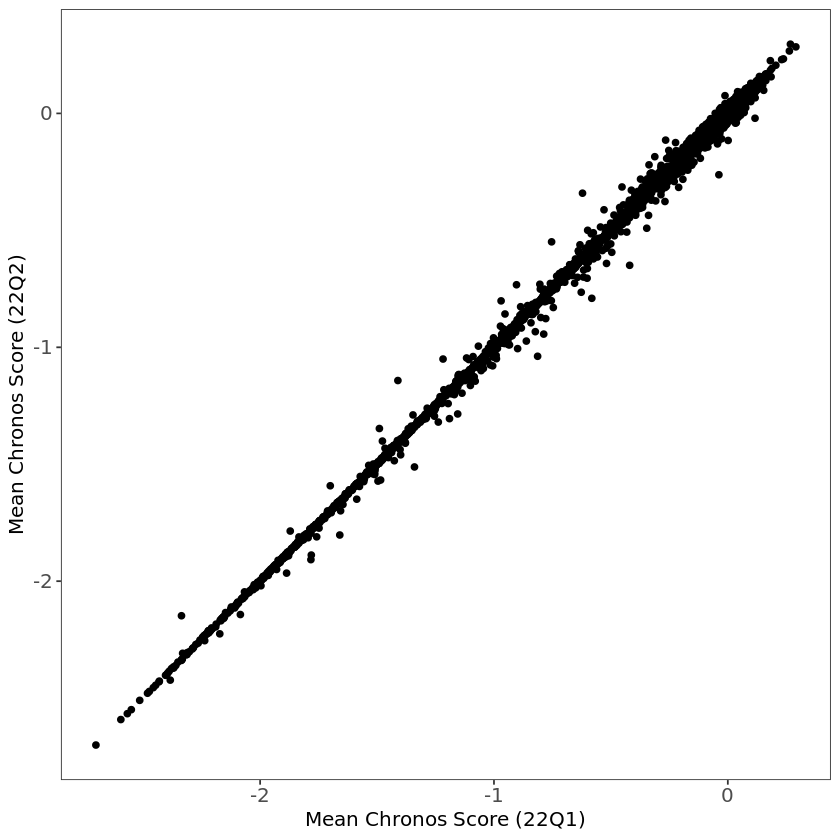

In [5]:
#Now plot the scatterplot
merged.mean.chronos.scores %>%
ggplot(aes(x = mean_22q1_score, y = mean_22q2_score)) +
geom_point() +

theme_bw() +

scale_color_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Mean Chronos Score (22Q2)") +
xlab("Mean Chronos Score (22Q1)")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c6_correlation.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c6_correlation.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Create a volcano plot with the same data

In [6]:
#Filter the two datasets so that they have overlapping samples and genes (again)
chronos.22q1.filtered = ccle.chronos %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample)

chronos.22q2.filtered = ccle.chronos.new %>%
filter(sample %in% all_of(overlapping.samples)) %>%
select(-sample)

In [7]:
#Compute the p-values between the two data frames 
pvals = Map(wilcox.test, chronos.22q1.filtered, chronos.22q2.filtered)

extracted.pvals = pvals %>% lapply(function(x){
    val = x$p.value
    return(val)
}) %>%
unlist() %>%
as.numeric()

In [8]:
#Create a data frame with the p-values and the mean differences
difference.between.22q1.22q2.df = cbind(colnames(chronos.22q1.filtered), extracted.pvals, merged.mean.chronos.scores$differential) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "differential" = 3) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(differential = as.numeric(differential)) %>%
mutate("fdr" = p.adjust(pval, method = "BH", n = length(pval)))

Warning message in cbind(colnames(chronos.22q1.filtered), extracted.pvals, merged.mean.chronos.scores$differential):
“number of rows of result is not a multiple of vector length (arg 3)”


In [9]:
#Calculate the total number of significant differences
difference.between.22q1.22q2.df %>% 
filter(fdr < 0.05) %>%
pull(gene) %>%
unique() %>%
length()

[1] 2223

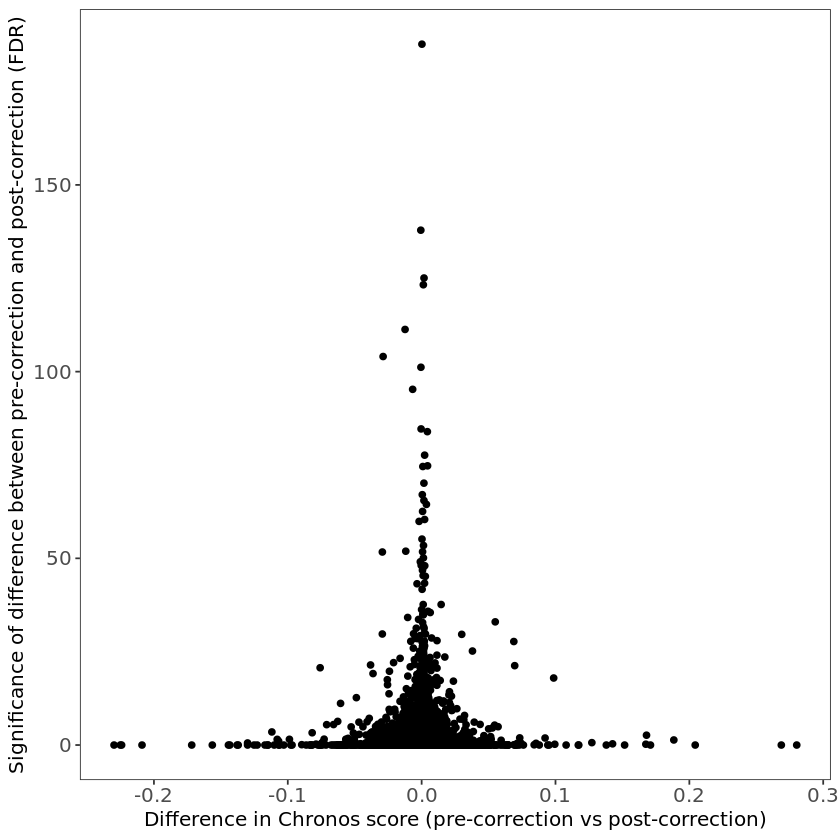

In [12]:
#Plot the volcano plot
difference.between.22q1.22q2.df %>%
ggplot(aes(x = differential, y = -log10(fdr))) +
geom_point() +
theme_bw() +

scale_color_manual(values = c("black", "blue")) +
scale_fill_manual(values = c("black", "blue")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(size = 12),
axis.title.y = element_text(size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Significance of difference between pre-correction and post-correction (FDR)") +
xlab("Difference in Chronos score (pre-correction vs post-correction)")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c6_volcano.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c6_volcano.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Now calculate p-values for the different ancestry groups for all ancestry-associated variants using both the old and the new chronos data

In [13]:
#Load in the gene block matrix to save a bunch of compute time if I ever need to re-make the figure
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")
gene.block.matrix = read.table("gene.block.matrix.txt", sep = "\t", header = T)
row.names(gene.block.matrix) = NULL

#Format gene.block.matrix so that it is ready for our analysis
formatted.gene.block.matrix = gene.block.matrix %>%
column_to_rownames(var = "gene") %>%
select(-block_id, -X.chm, -spos, -epos) %>%
t() %>%
data.frame() %>%
rownames_to_column() %>%
rename("sample" = 1) %>%
mutate(sample = gsub("ACH.000", "ACH-000", sample)) %>%
mutate(sample = gsub("\\.1", "", sample))


head(formatted.gene.block.matrix)

,sample,TGIF1,PRDX6,CIC,PLEC,MPP2,CFTR,C1QB,ELN,SEPTIN12,⋯,GTF2H2C,TTC31,PDE8B,CHD1,PAK1,LOC284898,PRKD3,MLC1,ZBTB41,TMEM181
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ACH-000657,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,ACH-000617,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,0,3
3,ACH-000685,0,0,3,0,0,0,0,0,3,⋯,0,0,0,0,0,0,0,3,0,2
4,ACH-000632,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
5,ACH-000171,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3
6,ACH-000863,3,3,3,3,3,3,3,3,3,⋯,3,3,3,3,3,3,3,3,3,3


In [14]:
#Filter both datasets so that they share a common set of samples
intersecting.samples = intersect(ccle.chronos$sample, formatted.gene.block.matrix$sample)
intersecting.genes = intersect(colnames(ccle.chronos), colnames(formatted.gene.block.matrix))

final.ccle.chronos = ccle.chronos %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

final.ccle.chronos.new = ccle.chronos.new %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

final.gene.block = formatted.gene.block.matrix %>%
filter(sample %in% intersecting.samples) %>%
select(all_of(intersecting.genes)) %>%
arrange(sample)

In [15]:
###For the 22Q1 chronos data

gene.names = colnames(final.gene.block)[2:ncol(final.gene.block)]

afr.pval.vector = NULL
amr.pval.vector = NULL
eas.pval.vector = NULL
eur.pval.vector = NULL
sas.pval.vector = NULL
afr.mean.dif = NULL
amr.mean.dif = NULL
eas.mean.dif = NULL
eur.mean.dif = NULL
sas.mean.dif = NULL
for(gene in gene.names){
        
   #Filter the chronos data so that it only includes the gene we are interested in 
   chronos.filtered = final.ccle.chronos %>% select(sample, all_of(gene))
    
   #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = wilcox.test(afr.chronos, non.afr.chronos)$p.value
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = wilcox.test(amr.chronos, non.amr.chronos)$p.value 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = wilcox.test(eas.chronos, non.eas.chronos)$p.value 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = wilcox.test(eur.chronos, non.eur.chronos)$p.value 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = wilcox.test(sas.chronos, non.sas.chronos)$p.value 
    } else { sas.pval = 1 }
    

    
    #Add the p-values to the vector outside of the loop
    afr.pval.vector = c(afr.pval.vector, afr.pval)
    amr.pval.vector = c(amr.pval.vector, amr.pval)
    eas.pval.vector = c(eas.pval.vector, eas.pval)
    eur.pval.vector = c(eur.pval.vector, eur.pval)
    sas.pval.vector = c(sas.pval.vector, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif = c(afr.mean.dif, afr.dif)
    amr.mean.dif = c(amr.mean.dif, amr.dif)
    eas.mean.dif = c(eas.mean.dif, eas.dif)
    eur.mean.dif = c(eur.mean.dif, eur.dif)
    sas.mean.dif = c(sas.mean.dif, sas.dif)
}

In [ ]:
###For the22Q2 Chronos data

gene.names = colnames(final.gene.block)[2:ncol(final.gene.block)]

afr.pval.vector.new = NULL
amr.pval.vector.new = NULL
eas.pval.vector.new = NULL
eur.pval.vector.new = NULL
sas.pval.vector.new = NULL
afr.mean.dif.new = NULL
amr.mean.dif.new = NULL
eas.mean.dif.new = NULL
eur.mean.dif.new = NULL
sas.mean.dif.new = NULL
for(gene in gene.names){
        
   #Filter the chronos data so that it only includes the gene we are interested in 
   chronos.filtered = final.ccle.chronos.new %>% select(sample, all_of(gene))
    
   #Filter the gene block data so that it only includes the gene we are interested in
    gene.block.filtered = final.gene.block %>% select(sample, all_of(gene)) %>% rename("gene.symbol" = 2)
    
    #For each gene in the loop, figure out which cell lines have the version of that gene for each ancestry group
    afr.lines = gene.block.filtered %>% filter(gene.symbol %in% "0") %>% pull(sample)
    non.afr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "0") %>% pull(sample)
    amr.lines = gene.block.filtered %>% filter(gene.symbol %in% "1") %>% pull(sample)
    non.amr.lines = gene.block.filtered %>% filter(!gene.symbol %in% "1") %>% pull(sample)
    eas.lines = gene.block.filtered %>% filter(gene.symbol %in% "2") %>% pull(sample)
    non.eas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "2") %>% pull(sample)
    eur.lines = gene.block.filtered %>% filter(gene.symbol %in% "3") %>% pull(sample)
    non.eur.lines = gene.block.filtered %>% filter(!gene.symbol %in% "3") %>% pull(sample)
    sas.lines = gene.block.filtered %>% filter(gene.symbol %in% "4") %>% pull(sample)
    non.sas.lines = gene.block.filtered %>% filter(!gene.symbol %in% "4") %>% pull(sample)
    
    #Now get vectors of chronos scores for each ancestry group
    afr.chronos = chronos.filtered %>% filter(sample %in% afr.lines) %>% pull(2)
    non.afr.chronos = chronos.filtered %>% filter(sample %in% non.afr.lines) %>% pull(2)
    
    amr.chronos = chronos.filtered %>% filter(sample %in% amr.lines) %>% pull(2)
    non.amr.chronos = chronos.filtered %>% filter(sample %in% non.amr.lines) %>% pull(2)
    
    eas.chronos = chronos.filtered %>% filter(sample %in% eas.lines) %>% pull(2)
    non.eas.chronos = chronos.filtered %>% filter(sample %in% non.eas.lines) %>% pull(2)
    
    eur.chronos = chronos.filtered %>% filter(sample %in% eur.lines) %>% pull(2)
    non.eur.chronos = chronos.filtered %>% filter(sample %in% non.eur.lines) %>% pull(2)
    
    sas.chronos = chronos.filtered %>% filter(sample %in% sas.lines) %>% pull(2)
    non.sas.chronos = chronos.filtered %>% filter(sample %in% non.sas.lines) %>% pull(2)
    
    
    #Now calculate the p-values for each comparison (if there are more than three observations)
    if(length(afr.chronos) >= 3 & length(non.afr.chronos) >= 3){
        afr.pval = wilcox.test(afr.chronos, non.afr.chronos)$p.value
    } else { afr.pval = 1 }
    
      if(length(amr.chronos) >= 3 & length(non.amr.chronos) >= 3){
        amr.pval = wilcox.test(amr.chronos, non.amr.chronos)$p.value 
    } else { amr.pval = 1 }
    
      if(length(eas.chronos) >= 3 & length(non.eas.chronos) >= 3){
        eas.pval = wilcox.test(eas.chronos, non.eas.chronos)$p.value 
    } else { eas.pval = 1 }
    
      if(length(eur.chronos) >= 3 & length(non.eur.chronos) >= 3){
        eur.pval = wilcox.test(eur.chronos, non.eur.chronos)$p.value 
    } else { eur.pval = 1 }
    
      if(length(sas.chronos) >= 3 & length(non.sas.chronos) >= 3){
        sas.pval = wilcox.test(sas.chronos, non.sas.chronos)$p.value 
    } else { sas.pval = 1 }
    

    
    #Add the p-values to the vector outside of the loop
    afr.pval.vector.new = c(afr.pval.vector.new, afr.pval)
    amr.pval.vector.new = c(amr.pval.vector.new, amr.pval)
    eas.pval.vector.new = c(eas.pval.vector.new, eas.pval)
    eur.pval.vector.new = c(eur.pval.vector.new, eur.pval)
    sas.pval.vector.new = c(sas.pval.vector.new, sas.pval)
    
    
    #Calculate the differences in means
    afr.dif = mean(afr.chronos) - mean(non.afr.chronos)
    amr.dif = mean(amr.chronos) - mean(non.amr.chronos)
    eas.dif = mean(eas.chronos) - mean(non.eas.chronos)
    eur.dif = mean(eur.chronos) - mean(non.eur.chronos)
    sas.dif = mean(sas.chronos) - mean(non.sas.chronos)
    
    #Add the mean differences to the vectors
    afr.mean.dif.new = c(afr.mean.dif.new, afr.dif)
    amr.mean.dif.new = c(amr.mean.dif.new, amr.dif)
    eas.mean.dif.new = c(eas.mean.dif.new, eas.dif)
    eur.mean.dif.new = c(eur.mean.dif.new, eur.dif)
    sas.mean.dif.new = c(sas.mean.dif.new, sas.dif)
}

In [ ]:
#First, create datasets for each ancestry group, then cat them for 22q1
afr.volcano.df = cbind(gene.names, afr.pval.vector, afr.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AFR")

amr.volcano.df = cbind(gene.names, amr.pval.vector, amr.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AMR")

eas.volcano.df = cbind(gene.names, eas.pval.vector, eas.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EAS")

eur.volcano.df = cbind(gene.names, eur.pval.vector, eur.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EUR")

sas.volcano.df = cbind(gene.names, sas.pval.vector, sas.mean.dif) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "SAS")

cat.volcano.df = rbind(afr.volcano.df, amr.volcano.df, eas.volcano.df, eur.volcano.df, sas.volcano.df) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(difference = as.numeric(difference)) %>%
mutate(FDR = p.adjust(pval, method = "BH", n = length(pval)))

head(cat.volcano.df)

setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
write.table(cat.volcano.df, "22q1_ancestry_associated_pvals.txt", sep = "\t", col.names = T, row.names = F)

In [ ]:
#Now do the same for 22q2
afr.volcano.df.new = cbind(gene.names, afr.pval.vector.new, afr.mean.dif.new) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AFR")

amr.volcano.df.new = cbind(gene.names, amr.pval.vector.new, amr.mean.dif.new) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "AMR")

eas.volcano.df.new = cbind(gene.names, eas.pval.vector.new, eas.mean.dif.new) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EAS")

eur.volcano.df.new = cbind(gene.names, eur.pval.vector.new, eur.mean.dif.new) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "EUR")

sas.volcano.df.new = cbind(gene.names, sas.pval.vector.new, sas.mean.dif.new) %>%
data.frame() %>%
rename("gene" = 1, "pval" = 2, "difference" = 3) %>%
mutate("ancestry" = "SAS")

cat.volcano.df.new = rbind(afr.volcano.df.new, amr.volcano.df.new, eas.volcano.df.new, eur.volcano.df.new, sas.volcano.df.new) %>%
mutate(pval = as.numeric(pval)) %>%
mutate(difference = as.numeric(difference)) %>%
mutate(FDR = p.adjust(pval, method = "BH", n = length(pval)))

head(cat.volcano.df.new)

setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
write.table(cat.volcano.df.new, "22q2_ancestry_associated_pvals.txt", sep = "\t", col.names = T, row.names = F)

In [16]:
#Load the p-values back in
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
cat.volcano.df = read.table("22q1_ancestry_associated_pvals.txt", sep = "\t", header = T)
cat.volcano.df.new = read.table("22q2_ancestry_associated_pvals.txt", sep = "\t", header = T)

In [17]:
#Now combine the two datasets

#First make everything look nice
cat.volcano.df = cat.volcano.df %>%
rename("pval_22q1" = 2, "difference_22q1" = 3, "fdr_22q1" = 5) %>%
mutate("flag" = paste(gene, "_", ancestry, sep = ""))

cat.volcano.df.new = cat.volcano.df.new %>%
rename("pval_22q2" = 2, "difference_22q2" = 3, "fdr_22q2" = 5) %>%
mutate("flag" = paste(gene, "_", ancestry, sep = ""))


#Merge them together
merged.pvalue.data.frame = inner_join(cat.volcano.df, cat.volcano.df.new, by = "flag")

In [18]:
#Calculate the number of significant genes in each quadrant
merged.pvalue.data.frame %>% filter(fdr_22q1 < 0.05) %>% pull(gene.x) %>% unique() %>% length()
merged.pvalue.data.frame %>% filter(fdr_22q2 < 0.05) %>% pull(gene.y) %>% unique() %>% length()
merged.pvalue.data.frame %>% filter(fdr_22q1 < 0.05 & fdr_22q2 < 0.05) %>% pull(gene.x) %>% unique() %>% length()

[1] 98

[1] 57

[1] 54

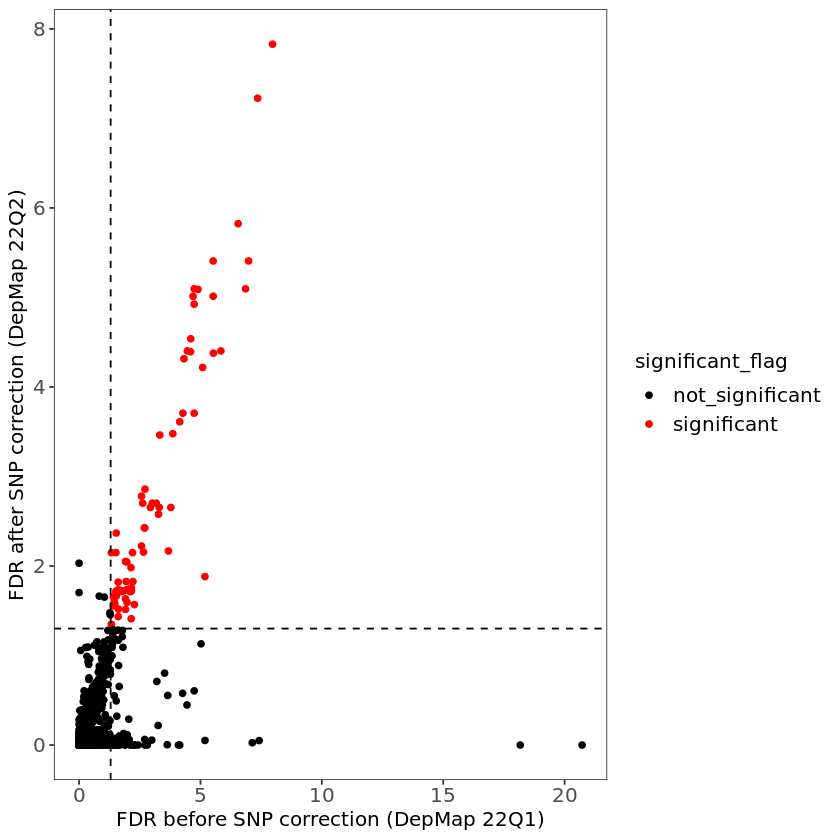

In [20]:
#Plot the plot
merged.pvalue.data.frame %>%
mutate("significant_flag" = ifelse(fdr_22q1 < 0.05 & fdr_22q2 < 0.05, "significant", "not_significant")) %>%
ggplot(aes(x = -log10(fdr_22q1), y = -log10(fdr_22q2), color = significant_flag)) +
geom_point() +
geom_hline(yintercept = -log10(0.05), linetype = 2) +
geom_vline(xintercept = -log10(0.05), linetype = 2) +

theme_bw() +

scale_color_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("FDR after SNP correction (DepMap 22Q2)") +
xlab("FDR before SNP correction (DepMap 22Q1)")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c6_volcano.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c6_volcano.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Compute the overlap of "common essential" genes between 22Q1 and 22Q2

In [64]:
#Load in the common essential genes
common.essential.22q1 = load.from.taiga(data.name='public-22q1-305b', data.version=24, data.file='CRISPR_common_essentials') %>%
mutate(gene = word(gene, 1))
common.essential.22q2 = load.from.taiga(data.name='public-22q2-de04', data.version=14, data.file='CRISPR_common_essentials') %>%
mutate(gene = word(gene, 1))

Fetching https://cds.team/taiga/api/dataset/public-22q1-305b/24 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q1-305b_24.toc 


Loading from cached file /home/jupyter/.taiga/90832e86cae84f918423ad1d83fa4222_crispr-common-essentials.rds



Fetching https://cds.team/taiga/api/dataset/public-22q2-de04/14 
Status 200 


No encoding supplied: defaulting to UTF-8.



loading cached data version from  /home/jupyter/.taiga/public-22q2-de04_14.toc 
Could not find public-22q2-de04 v14 in cache, requesting from taiga...
Fetching https://cds.team/taiga/api/datafile?format=rds&dataset_version_id=72c31542d4034fd8aa4f0b25e91e8ce6&datafile_name=CRISPR_common_essentials 
Status 200 


No encoding supplied: defaulting to UTF-8.



Taiga needs to convert data to rds before we can fetch it.  Waiting...
Conversion pending 
Fetching https://cds.team/taiga/api/datafile?format=rds&dataset_version_id=72c31542d4034fd8aa4f0b25e91e8ce6&datafile_name=CRISPR_common_essentials 
Status 200 


No encoding supplied: defaulting to UTF-8.



Running conversion 
Fetching https://cds.team/taiga/api/datafile?format=rds&dataset_version_id=72c31542d4034fd8aa4f0b25e91e8ce6&datafile_name=CRISPR_common_essentials 
Status 200 


No encoding supplied: defaulting to UTF-8.



Uploading converted file to S3 
Fetching https://cds.team/taiga/api/datafile?format=rds&dataset_version_id=72c31542d4034fd8aa4f0b25e91e8ce6&datafile_name=CRISPR_common_essentials 
Status 200 


No encoding supplied: defaulting to UTF-8.




  |======================================================================| 100%
Saving public-22q2-de04 v14 in cache ( 72c31542d4034fd8aa4f0b25e91e8ce6 CRISPR_common_essentials )...


Saved to cache as 72c31542d4034fd8aa4f0b25e91e8ce6_crispr-common-essentials.rds



writing /home/jupyter/.taiga/72c31542d4034fd8aa4f0b25e91e8ce6_crispr-common-essentials.idx /home/jupyter/.taiga/public-22q2-de04_crispr-common-essentials_14.idx 


In [67]:
#Calculate the intersection between the two
ce.gene.vector.22q1 = common.essential.22q1 %>% pull(gene) %>% unique()
ce.gene.vector.22q2 = common.essential.22q2 %>% pull(gene) %>% unique()

length(ce.gene.vector.22q1)
length(ce.gene.vector.22q2)
intersect(ce.gene.vector.22q1, ce.gene.vector.22q2) %>% length()

setdiff(ce.gene.vector.22q1, ce.gene.vector.22q2)
setdiff(ce.gene.vector.22q2, ce.gene.vector.22q1)

[1] 1923

[1] 1912

[1] 1899

[1] "AK2"      "ASS1"     "BCAR1"    "CADM4"    "CASTOR3"  "CIT"     
 [7] "COIL"     "FIS1"     "HSP90AB1" "IMPDH2"   "KATNB1"   "MEIOC"   
[13] "MRPS25"   "NAA30"    "NAMPT"    "NFATC2IP" "NFRKB"    "OLFML3"  
[19] "RARS2"    "SDC1"     "SMIM3"    "TMEM230"  "UCHL5"    "UNC50"

[1] "ARTN"     "ATP5PO"   "C18orf21" "CCDC43"   "CYFIP1"   "GFM1"    
 [7] "HNRNPR"   "ICE2"     "NDUFA2"   "PARS2"    "SCARF1"   "SMG7"    
[13] "STARD7"

# Comment 7

The goal of this analysis is to calculate how good the top 10 CRISPick guides are.

All of the data in this analysis is from John Doench's paper:

https://www.nature.com/articles/s41467-022-33024-2#Sec23

In [75]:
#Load in the data
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
guide.tiling.annotation = read.table("Guide_Tiling_Annotation.txt", sep = "\t", header = T)
guide.tiling.logfc = read.table("Guide_Tiling_Depletion.txt", sep = "\t", header = T)

In [73]:
#Get a list of genes that are included in the library
genes.in.library = guide.tiling.annotation %>% pull(Target.Gene.Symbol) %>% unique()

#Write the list, because we need to put it into CRISPick so that we can get the picking order for all of the guides
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
write.table(genes.in.library, "genes_in_doench_tiling_library.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [106]:
#Load in the CRISPick picking order
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
crispick.picking.order = read.table("f0ce1bf9-sgrna-designs.txt", sep = "\t", header = T) %>%
dplyr::select(Target.Gene.Symbol, sgRNA.Sequence, Pick.Order)

In [99]:
#Calculate the median guide activity
guide.logfc = guide.tiling.logfc %>%
dplyr::select(-sgRNA.Sequence, -pDNA) %>%
apply(1, mean) %>%
data.frame() %>%
rename("rep_mean" = 1) %>%
mutate("pdna" = guide.tiling.logfc$pDNA, .before = 1) %>%
mutate("sgrna" = guide.tiling.logfc$sgRNA.Sequence, .before = 1) %>%
mutate("sgrna_lognorm" = log2((rep_mean/sum(rep_mean))*1000000 + 1)) %>%
mutate("pdna_lognorm" = log2((pdna/sum(pdna))*1000000 + 1)) %>%
mutate("logfc" = sgrna_lognorm - pdna_lognorm)


head(guide.logfc)

,sgrna,pdna,rep_mean,sgrna_lognorm,pdna_lognorm,logfc
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,AAAAAAAAGCACTGTCATGC,161,3054.3333,4.897044,3.409039,1.4880041
2,AAAAAAAGCACTGTCATGCA,183,2278.3333,4.490563,3.577402,0.9131612
3,AAAAAAAGGGAGGACCACTG,160,685.6667,2.900025,3.400899,-0.5008742
4,AAAAAAAGGGCTGCCCCAAA,259,1311.0000,3.739845,4.042603,-0.3027584
5,AAAAAAAGTAGTGTGAAGTC,177,768.0000,3.042754,3.533398,-0.4906449
6,AAAAAAATGGGGACATTGGA,105,1161.0000,3.578430,2.863044,0.7153863


In [113]:
#Create a nice formatted dataset 
crispick.pick.order.and.logfc = crispick.picking.order %>%
mutate("logfc" = sgRNA.Sequence) %>%
mutate(logfc = plyr::mapvalues(from = guide.logfc$sgrna, to = guide.logfc$logfc, logfc, warn_missing = FALSE)) %>%
mutate(logfc = as.numeric(logfc)) %>% #Convert to numeric to force all missing guides to be NA
na.omit() #Remove all of the NA guides

head(crispick.pick.order.and.logfc)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


,Target.Gene.Symbol,sgRNA.Sequence,Pick.Order,logfc
,<chr>,<chr>,<int>,<dbl>
1,ATP5F1B,GGTGGACGTCCAGTTTGATG,1,-1.757903
2,ATP5F1B,TCTGCTAGCTCCCTATGCCA,2,-2.254599
3,ATP5F1B,GTTGGTGAGAGGACCCGTGA,3,-2.180871
4,ATP5F1B,CAGCCCAGTCAGAGCTACCC,4,-1.581698
5,ATP5F1B,CAAACACAGAGTAACCACCA,5,-1.158713
6,ATP5F1B,GTAAGGACTATTGCTATGGA,6,-1.722683


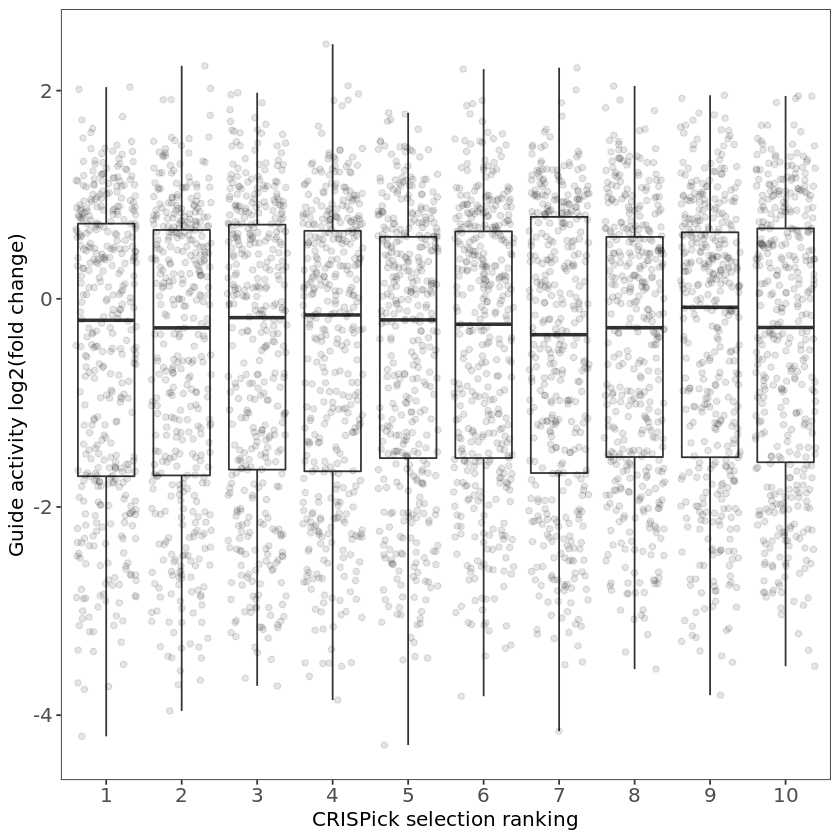

In [127]:
#Make a nice looking plot 
crispick.pick.order.and.logfc %>%
mutate(Pick.Order = factor(Pick.Order, levels = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10))) %>%
ggplot(aes(x = Pick.Order, y = logfc)) +
geom_boxplot() +
geom_jitter(alpha = 0.1) + 

theme_bw() +

scale_color_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Guide activity log2(fold change)") +
xlab("CRISPick selection ranking")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c7_boxplot.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c7_boxplot.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))



Do the analysis with the pre-computed z-scores

In [15]:
#Load in the z-score dataset
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
doench.z.scores = read.table("guide_hsu_z_scores.txt", sep = "\t", header = T) %>%
rename("sgrna" = 1, "gene" = 2, "zscore" = 3)

,sgrna,gene,zscore
,<chr>,<chr>,<dbl>
1,AAAAAAAGGGAGGACCACTG,WDR55,-0.40152817
2,AAAAAAAGTAGTGTGAAGTC,LUC7L3,0.78624190
3,AAAAAACAAAAGTAGCGCAT,GET4,0.96182997
4,AAAAAACAGCAGGGGATGGC,DNTTIP2,0.54608409
5,AAAAAACTCTCTCCGGGTCA,PDCD11,1.20843325
6,AAAAAAGCAGCTGCTTTCAG,TTK,-0.03835796


In [17]:
#Load in the CRISPick picking order
setwd("/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1")
crispick.picking.order = read.table("f0ce1bf9-sgrna-designs.txt", sep = "\t", header = T) %>%
dplyr::select(Target.Gene.Symbol, sgRNA.Sequence, Pick.Order) 

head(crispick.picking.order)

,Target.Gene.Symbol,sgRNA.Sequence,Pick.Order
,<chr>,<chr>,<int>
1,ATP5F1B,GGTGGACGTCCAGTTTGATG,1
2,ATP5F1B,TCTGCTAGCTCCCTATGCCA,2
3,ATP5F1B,GTTGGTGAGAGGACCCGTGA,3
4,ATP5F1B,CAGCCCAGTCAGAGCTACCC,4
5,ATP5F1B,CAAACACAGAGTAACCACCA,5
6,ATP5F1B,GTAAGGACTATTGCTATGGA,6


In [19]:
#annotate the data frame so that it has the picking order
annotated.zscores = doench.z.scores %>%
filter(sgrna %in% all_of(crispick.picking.order$sgRNA.Sequence)) %>%
mutate("pick_order" = plyr::mapvalues(from = crispick.picking.order$sgRNA.Sequence, to = crispick.picking.order$Pick.Order, sgrna, warn_missing = FALSE))

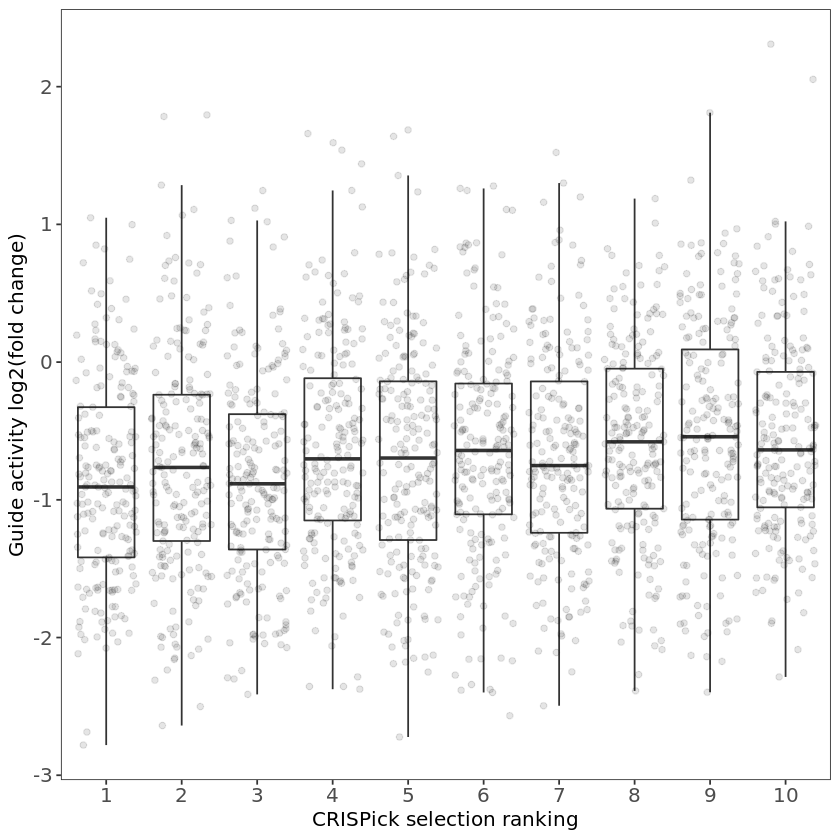

In [24]:
#Plot the plot
annotated.zscores %>%
mutate(pick_order = factor(pick_order, levels = c(1, 2, 3, 4, 5, 6, 7, 8, 9, 10))) %>%
ggplot(aes(x = pick_order, y = zscore)) +
geom_boxplot(outlier.shape = NA) +
geom_jitter(alpha = 0.1) + 

theme_bw() +

scale_color_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

ylab("Guide activity log2(fold change)") +
xlab("CRISPick selection ranking")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1')
ggsave("r1c7_boxplot_zscore.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/nature_genetics_reviews/reviewer_1
gsutil cp r1c7_boxplot_zscore.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))